In [1]:
# Imports
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn import tree, metrics
from sklearn.svm import SVR, LinearSVR
from sklearn.dummy import DummyRegressor
import housing
from sklearn.kernel_ridge import KernelRidge
# import lightgbm as ltb
import catboost as ctb
# import xgboost as xgb

In [2]:
# Load Datasets
train_data = pd.read_csv("train.csv", index_col="Id")

In [3]:
# Obtain target and feature columns.
target = "SalePrice"
all_features = train_data.drop(columns=target).columns

In [4]:
# Log-transform target
train_data['Log_SalePrice'] = np.log(train_data.SalePrice)
target = "Log_SalePrice"

In [5]:
# Perform feature extraction.
feature_extract = housing.FeatureExtracter()
X_train = feature_extract.fit_transform(train_data[all_features])

In [6]:
# Perform one-hot encoding for use with models that don't accept categorical types,
# and split into training and holdout sets.
onehot_encoder = ColumnTransformer([
        ("onehot", OneHotEncoder(drop="if_binary", handle_unknown="ignore", sparse=False), feature_extract.get_categorical_feature_names()),
    ], remainder=StandardScaler())

X_onehot_train, X_onehot_holdout, y_train, y_holdout = train_test_split(onehot_encoder.fit_transform(X_train), train_data[target], test_size=0.2, random_state=47)

In [7]:
# Perform ordinal encoding for use with models that do accept categorical types as integers (such as Trees),
# and split into training and holdout sets.
ordinal_encoder = ColumnTransformer([
        ("ordinal", OrdinalEncoder(), feature_extract.get_categorical_feature_names())
    ], remainder="passthrough")

X_ordinal_train, X_ordinal_holdout, _, _ = train_test_split(ordinal_encoder.fit_transform(X_train), train_data[target], test_size=0.2, random_state=47)

In [8]:
def fit_cv(model, X_train):
    """"Run cross validation, and return CV RMSE scores, and fit model using all training data."""
    cv_scores = cross_validate(model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1)
    model.fit(X_train, y_train)
    return cv_scores

def fit_grid_search_cv(model, param_grid, X_train):
    """"Run cross validation and return fit model using best params."""
    cv_model = GridSearchCV(model, param_grid, scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1, return_train_score=True)
    return cv_model.fit(X_train, y_train)

def get_rmse(model, X, y):
    return metrics.mean_squared_error(y, model.predict(X), squared=False)

def get_exp_rmse(model, X, y):
    return metrics.mean_squared_error(np.exp(y), np.exp(model.predict(X)), squared=False)

def print_results(model, mean_cv_score, X_train, X_holdout):
    print(f"    Mean CV RMSE: {-mean_cv_score:.4f}")
    print(f"    Train RMSE: {get_rmse(model, X_train, y_train):.4f}")
    print(f"    Holdout RMSE: {get_rmse(model, X_holdout, y_holdout):.4f}")
    print()
    print(f"    Train RMSE: ${get_exp_rmse(model, X_train, y_train):,.0f}")
    print(f"    Holdout RMSE: ${get_exp_rmse(model, X_holdout, y_holdout):,.0f}")

def print_nosearch_results(model, cv_scores, X_train, X_holdout):
    print_results(model, cv_scores['test_score'].mean(), X_train, X_holdout)

def print_search_results(best_model, X_train, X_holdout):
    print_results(best_model, best_model.best_score_, X_train, X_holdout)

In [9]:
def plot_validation_scores(search_cv_model, plot_param = None):
    """Plot validation curve with the specified `plot_param` on the x-axis and scores on the y-axis.
    
    If the search was over multiple params, then additional plots will be generated to sweep
    the other params (other than `plot_param`).
    """
    results = pd.DataFrame(search_cv_model.cv_results_)
    params = sorted(results.columns[results.columns.str.startswith("param_")].str.removeprefix("param_").to_list())
    if not plot_param:
        plot_param = params[0]
    if plot_param not in params:
        raise ValueError(f"Unexpected value for primary_param={plot_param}. Available params: {params}")
    params.remove(plot_param)
    
    line_width = 2

    if len(params) == 0:
        plot_groups = [("All params", results)]
    elif len(params) == 1:
        plot_groups = results.groupby(f"param_{params[0]}")
    else:
        plot_groups = results.groupby([f"param_{p}" for p in params])

    for param_vals, group_data in plot_groups:
        param_range = sorted(group_data[f"param_{plot_param}"].unique())
        train_scores_mean = -group_data.mean_train_score
        test_scores_mean = -group_data.mean_test_score
        is_logscale = abs((param_range[1] / param_range[0]) - 10) < 1e-6
        plot_func = plt.semilogx if is_logscale else plt.plot
        
        plot_func(param_range, train_scores_mean, label="Training score", color="darkorange", lw=line_width)
        plt.fill_between(param_range,
            train_scores_mean - group_data.std_train_score,
            train_scores_mean + group_data.std_train_score,
            alpha=0.2, color="darkorange", lw=line_width)
        
        plot_func(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=line_width)
        plt.fill_between(param_range,
            test_scores_mean - group_data.std_test_score,
            test_scores_mean + group_data.std_test_score,
            alpha=0.2, color="navy", lw=line_width)
        
        if len(params) == 1:
            plt.title(f"{params[0]}={param_vals}")
        elif len(params) > 1:
            plt.title(", ".join([f"{params[i]}={param_vals[i]}" for i in range(len(params))]))
        plt.xlabel(plot_param)
        plt.ylabel("RMSE")
        plt.legend(loc="best")
        plt.show()

# Train the simplest baseline model
- Goal: For each Id in the test set, predict the value of the SalePrice variable (the sales price for each house) 
- Evaluation Metric: Root-Mean-Squared-Error (RMSE)

In [38]:
# Using mean baseline (always predicts the mean of the training set)
mean_baseline = DummyRegressor(strategy='mean')
cv_scores = fit_cv(mean_baseline, X_onehot_train)
print("Mean Baseline:")
print_nosearch_results(mean_baseline, cv_scores, X_onehot_train, X_onehot_holdout)

Mean Baseline:
    Mean CV RMSE: 0.3973
    Train RMSE: 0.3975
    Holdout RMSE: 0.4064

    Train RMSE: $80,079
    Holdout RMSE: $83,172


In [39]:
# Using median baseline (always predicts the median of the training set)
median_baseline = DummyRegressor(strategy='median')
cv_scores = fit_cv(median_baseline, X_onehot_train)
print("Median Baseline:")
print_nosearch_results(median_baseline, cv_scores, X_onehot_train, X_onehot_holdout)

Median Baseline:
    Mean CV RMSE: 0.3974
    Train RMSE: 0.3978
    Holdout RMSE: 0.4069

    Train RMSE: $80,562
    Holdout RMSE: $83,693


# Find the best performing model

- Goal: For each Id in the test set, predict the value of the SalePrice variable (the sales price for each house). 
- Metric: Root-Mean-Squared-Error (RMSE)

1.	Which model would you choose and why (relate to relevant EDA)?
2.	Choose a validation creation process, why you choose it? what is the baseline performance?
3.	Which smart tricks you used to boost your model performance?
4.	Describe potential generalization issues (e.g. overfit/underfit)? How can you handle these?

## OLS Linear Regression

In [ ]:
ols = LinearRegression()
cv_scores = fit_cv(ols, X_onehot_train)
print("OLS:")
print_nosearch_results(ols, cv_scores, X_onehot_train, X_onehot_holdout)

## Ridge Regression

In [10]:
ridge = Pipeline([
    ('reg', Ridge()),
])
param_grid = {'reg__alpha': np.logspace(-5, 5, num=11)}
best_ridge = fit_grid_search_cv(ridge, param_grid, X_onehot_train)
best_params = best_ridge.best_params_
print(f"Ridge(alpha={best_params['reg__alpha']}):")
print_search_results(best_ridge, X_onehot_train, X_onehot_holdout)

Ridge(alpha=10.0):
    Mean CV RMSE: 0.1127
    Train RMSE: 0.0950
    Holdout RMSE: 0.2279

    Train RMSE: $17,263
    Holdout RMSE: $166,962


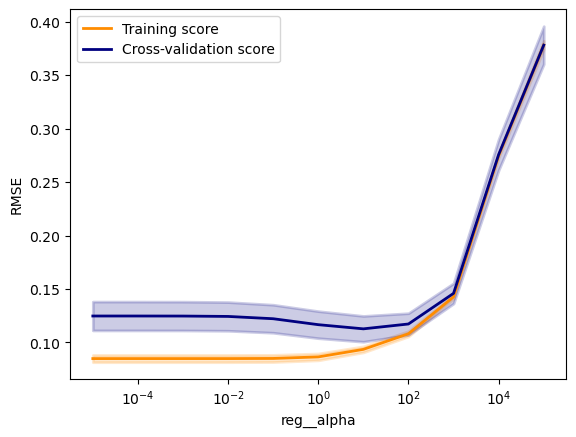

In [11]:
plot_validation_scores(best_ridge)

In [20]:
# Fine tuning
ridge = Pipeline([
    ('reg', Ridge()),
])
param_grid = {'reg__alpha': [100, 200, 300, 400, 500]}
best_ridge = fit_grid_search_cv(ridge, param_grid, X_onehot_train)
best_params = best_ridge.best_params_
print(f"Ridge(alpha={best_params['reg__alpha']}):")
print_search_results(best_ridge, X_onehot_train, X_onehot_holdout)

Ridge(alpha=100):
    Mean CV RMSE: 0.1173
    Train RMSE: 0.1077
    Holdout RMSE: 0.2213

    Train RMSE: $19,373
    Holdout RMSE: $147,394


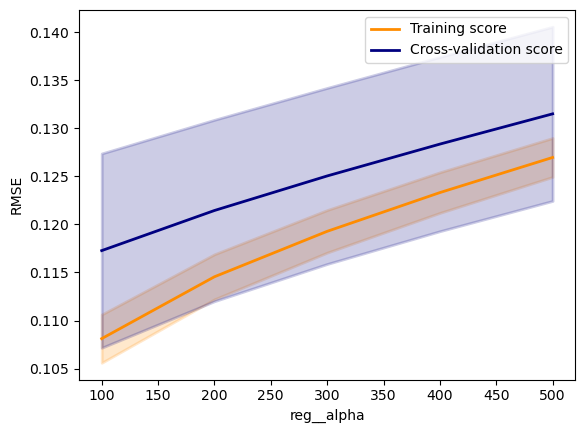

In [21]:
plot_validation_scores(best_ridge)

In [58]:
# Manually tuned
ridge = Pipeline([
    ('reg', Ridge(alpha=500)),
])
cv_scores = fit_cv(ridge, X_onehot_train)
print(f"Ridge:")
print_nosearch_results(ridge, cv_scores, X_onehot_train, X_onehot_holdout)

Ridge:
    Mean CV RMSE: 0.1315
    Train RMSE: 0.1240
    Holdout RMSE: 0.2083

    Train RMSE: $23,748
    Holdout RMSE: $106,957


## Bagged Ridge

In [28]:
bagged_ridge = BaggingRegressor(Ridge(alpha=100), n_jobs=-1)
param_grid = {
    "n_estimators": [100, 500],
    "max_samples": [0.5, 1.0],
    "max_features": [0.25, 0.5, 0.75, 1.0],
}
best_bagged_ridge = fit_grid_search_cv(bagged_ridge, param_grid, X_onehot_train)
best_params = best_bagged_ridge.best_params_
print(f"Bagged Ridge(n_estimators={best_params['n_estimators']}, max_samples={best_params['max_samples']:.2f}, max_features={best_params['max_features']:.2f}):")
print_search_results(best_bagged_ridge, X_onehot_train, X_onehot_holdout)

Bagged Ridge(n_estimators=100, max_samples=1.00, max_features=1.00):
    Mean CV RMSE: 0.1175
    Train RMSE: 0.1082
    Holdout RMSE: 0.2216

    Train RMSE: $19,555
    Holdout RMSE: $147,385


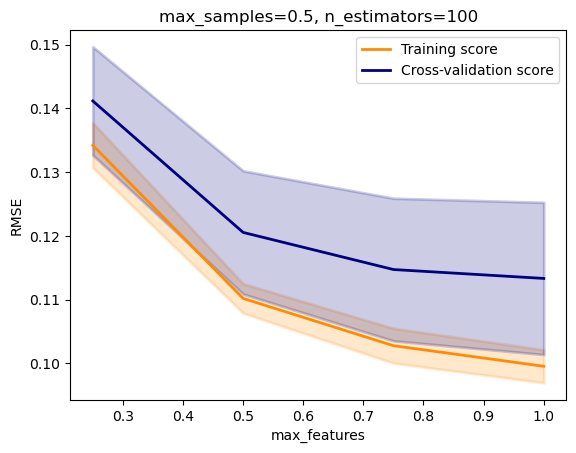

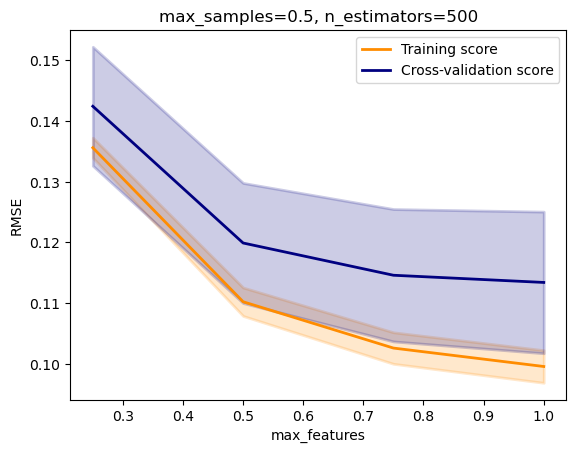

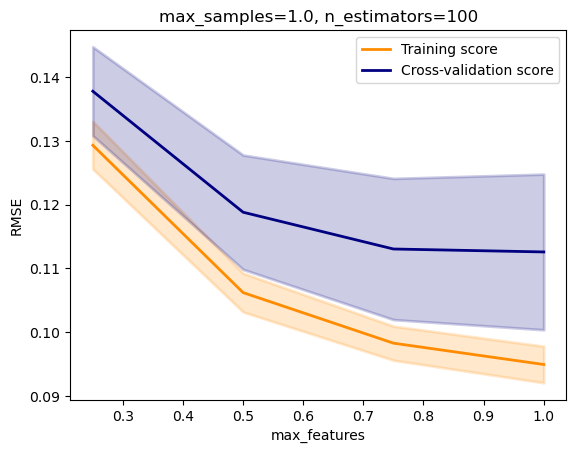

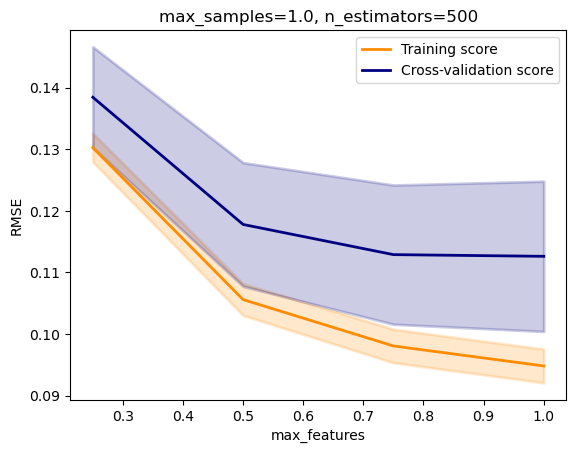

In [23]:
plot_validation_scores(best_bagged_ridge, "max_features")

In [27]:
# Manually tuned
bagged_ridge = BaggingRegressor(Ridge(alpha=200), n_estimators=500, max_samples=1.0, max_features=0.5, n_jobs=-1)
cv_scores = fit_cv(bagged_ridge, X_onehot_train)
print(f"Bagged Ridge:")
print_nosearch_results(bagged_ridge, cv_scores, X_onehot_train, X_onehot_holdout)

Bagged Ridge:
    Mean CV RMSE: 0.1376
    Train RMSE: 0.1295
    Holdout RMSE: 0.2021

    Train RMSE: $25,895
    Holdout RMSE: $90,184


## Lasso Regression

In [59]:
lasso = Pipeline([
    ('reg', Lasso()),
])
param_grid = {'reg__alpha': np.logspace(-5, 5, num=11)}
best_lasso = fit_grid_search_cv(lasso, param_grid, X_onehot_train)
best_params = best_lasso.best_params_
print(f"Lasso(alpha={best_params['reg__alpha']}):")
print_search_results(best_lasso, X_onehot_train, X_onehot_holdout)

Lasso(alpha=0.001):
    Mean CV RMSE: 0.1125
    Train RMSE: 0.1023
    Holdout RMSE: 0.2254

    Train RMSE: $18,506
    Holdout RMSE: $161,335


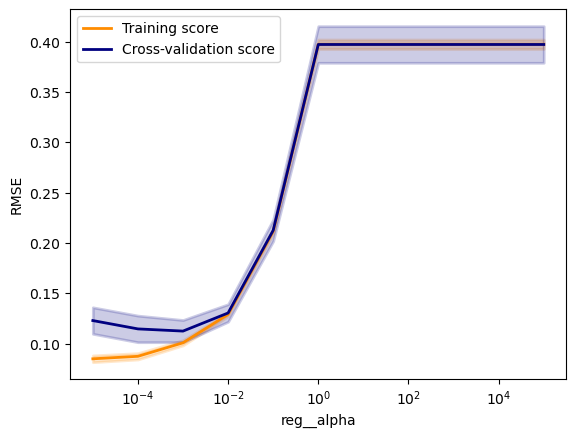

In [60]:
plot_validation_scores(best_lasso)

In [68]:
np.linspace(0.001, 0.02, num=20)

array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 ])

In [69]:
# Fine tuned.
lasso = Pipeline([
    ('reg', Lasso()),
])
param_grid = {'reg__alpha': np.linspace(0.001, 0.02, num=20)}
best_lasso = fit_grid_search_cv(lasso, param_grid, X_onehot_train)
best_params = best_lasso.best_params_
print(f"Lasso(alpha={best_params['reg__alpha']}):")
print_search_results(best_lasso, X_onehot_train, X_onehot_holdout)

Lasso(alpha=0.001):
    Mean CV RMSE: 0.1125
    Train RMSE: 0.1023
    Holdout RMSE: 0.2254

    Train RMSE: $18,506
    Holdout RMSE: $161,335


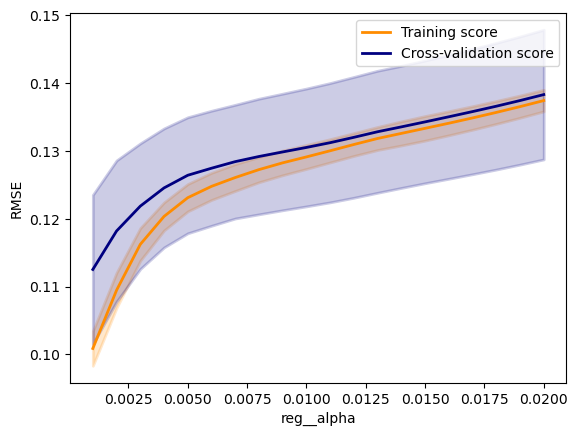

In [70]:
plot_validation_scores(best_lasso)

In [78]:
# Manually tuned.
lasso = Pipeline([
    ('reg', Lasso(alpha=0.001)),
])
cv_scores = fit_cv(lasso, X_onehot_train)
print(f"Lasso:")
print_nosearch_results(lasso, cv_scores, X_onehot_train, X_onehot_holdout)

Lasso:
    Mean CV RMSE: 0.1125
    Train RMSE: 0.1023
    Holdout RMSE: 0.2254

    Train RMSE: $18,506
    Holdout RMSE: $161,335


## Random Forest

In [81]:
rf = RandomForestRegressor(n_jobs=-1)
param_grid = {
    # Number of trees in random forest
    'n_estimators': [800, 1500],
    # Number of features to consider at every split
    'max_features': [0.5, "sqrt", 1.0],
    # Minimum number of samples required at each leaf node
    'min_samples_leaf': [1, 4, 8],
}
best_rf = fit_grid_search_cv(rf, param_grid, X_ordinal_train)
best_params = best_rf.best_params_
print(f"RandomForest(n_estimators={best_params['n_estimators']}, max_features={best_params['max_features']}, min_samples_leaf={best_params['min_samples_leaf']}):")
print_search_results(best_rf, X_ordinal_train, X_ordinal_holdout)

RandomForest(n_estimators=1500, max_features=0.5, min_samples_leaf=1):
    Mean CV RMSE: 0.1344
    Train RMSE: 0.0489
    Holdout RMSE: 0.1600

    Train RMSE: $10,293
    Holdout RMSE: $39,730


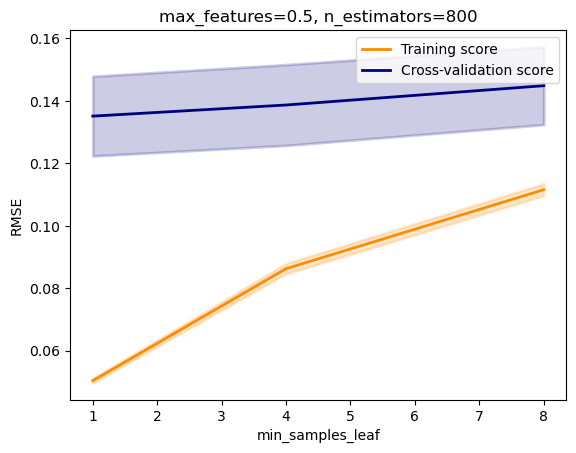

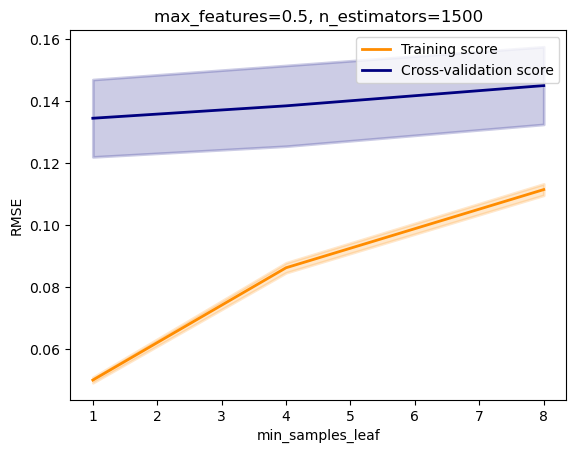

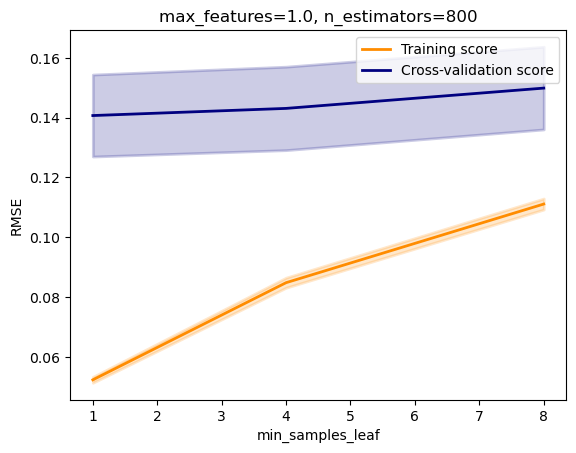

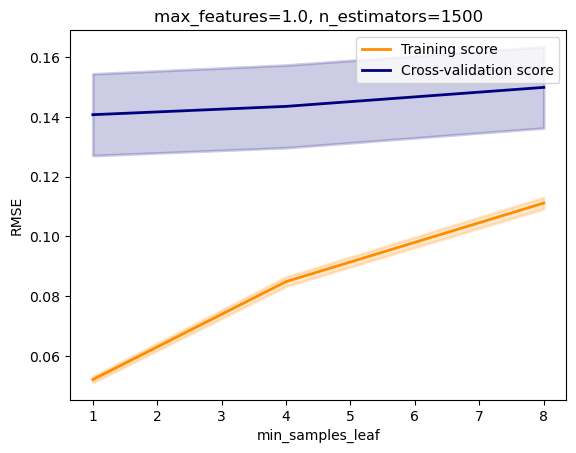

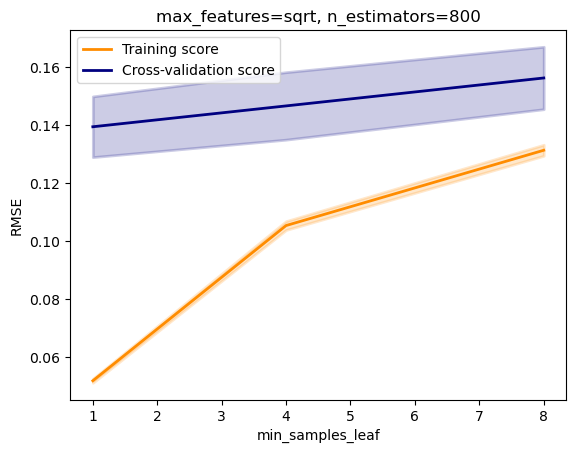

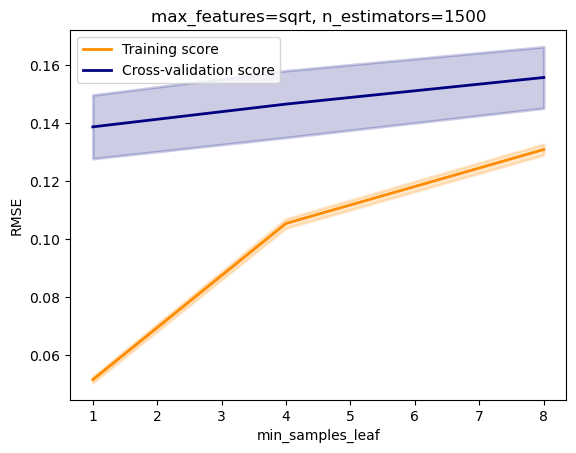

In [82]:
plot_validation_scores(best_rf, "min_samples_leaf")

In [87]:
# Manually tuned.
rf = RandomForestRegressor(n_estimators=1500, max_features=0.5, min_samples_leaf=8, n_jobs=-1)
cv_scores = fit_cv(rf, X_onehot_train)
print(f"Random Forest:")
print_nosearch_results(rf, cv_scores, X_onehot_train, X_onehot_holdout)

Random Forest:
    Mean CV RMSE: 0.1450
    Train RMSE: 0.1092
    Holdout RMSE: 0.1587

    Train RMSE: $23,680
    Holdout RMSE: $36,188


## Random Forest (one-hot encoded data)

In [43]:
rf_dummy = RandomForestRegressor(n_jobs=-1)
param_grid = {
    # Number of trees in random forest
    'n_estimators': [100, 200, 400, 800],
    # Number of features to consider at every split
    'max_features': [1.0, "sqrt"],
    # Minimum number of samples required at each leaf node
    'min_samples_leaf': [1, 2, 4],
}
best_rf = fit_grid_search_cv(rf_dummy, param_grid, X_onehot_train)
best_params = best_rf.best_params_
print(f"RandomForest(n_estimators={best_params['n_estimators']}, max_features={best_params['max_features']}, min_samples_leaf={best_params['min_samples_leaf']}):")
print_search_results(best_rf, X_onehot_train, X_onehot_holdout)

RandomForest(n_estimators=800, max_features=1.0, min_samples_leaf=1):
    Mean CV RMSE: 0.1406
    Train RMSE: 0.0509
    Holdout RMSE: 0.1658

    Train RMSE: $10,585
    Holdout RMSE: $41,473


## Linear SVM

In [44]:
linear_svm = Pipeline([
    ('reg', LinearSVR(max_iter=100000)),
])
param_grid = {'reg__C': np.logspace(-3, 7, num=11)}
best_linear_svm = fit_grid_search_cv(linear_svm, param_grid, X_onehot_train)
best_params = best_linear_svm.best_params_
print(f"Linear SVM(C={best_params['reg__C']}):")
print_search_results(best_linear_svm, X_onehot_train, X_onehot_holdout)

Linear SVM(C=1.0):
    Mean CV RMSE: 0.1267
    Train RMSE: 0.0976
    Holdout RMSE: 0.2335

    Train RMSE: $17,606
    Holdout RMSE: $159,123


## RBF SVM

In [32]:
rbf_svm = Pipeline([
    ('reg', SVR(kernel="rbf")),
])
param_grid = {
    'reg__C': np.linspace(0.1, 1.5, num=15),
    'reg__epsilon': np.logspace(-5, -1, num=5),
    }
best_rbf_svm = fit_grid_search_cv(rbf_svm, param_grid, X_onehot_train)
best_params = best_rbf_svm.best_params_
print(f"RBF SVM(C={best_params['reg__C']}, epsilon={best_params['reg__epsilon']}):")
print_search_results(best_rbf_svm, X_onehot_train, X_onehot_holdout)

RBF SVM(C=0.9999999999999999, epsilon=0.001):
    Mean CV RMSE: 0.1281
    Train RMSE: 0.0469
    Holdout RMSE: 0.1331

    Train RMSE: $7,078
    Holdout RMSE: $29,275


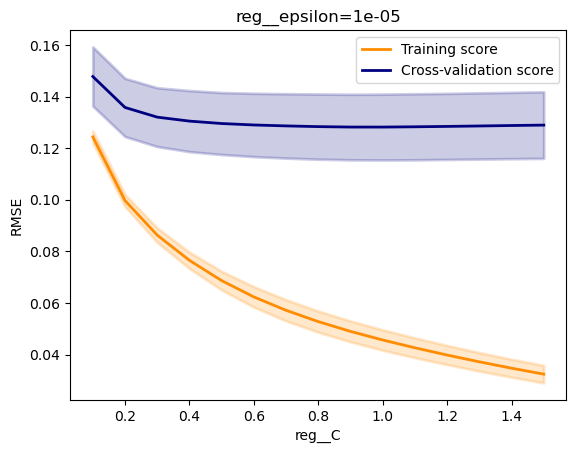

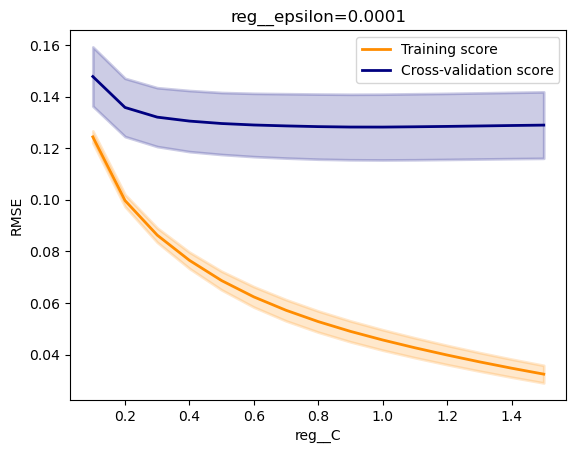

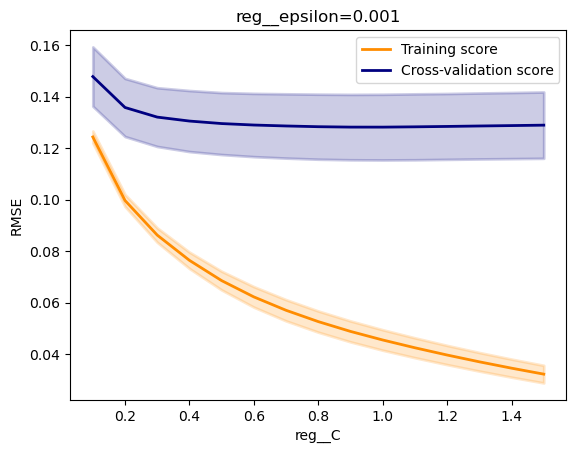

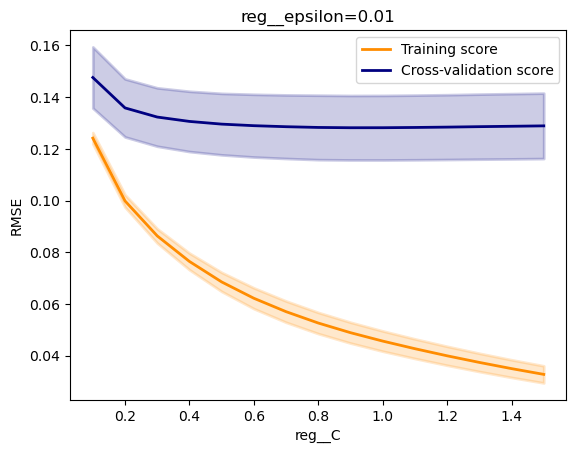

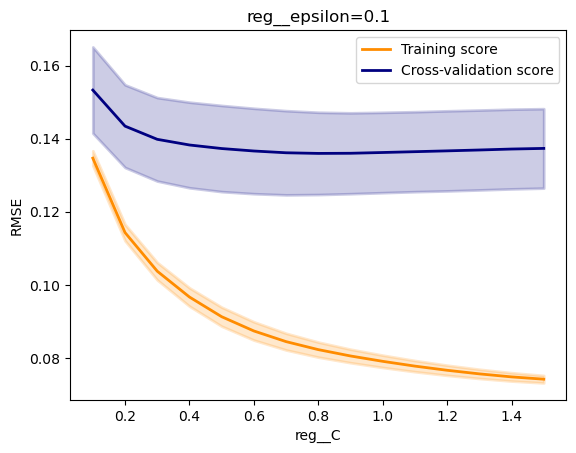

In [128]:
plot_validation_scores(best_rbf_svm, "reg__C")

In [40]:
# Manually tuned.
rbf_svm = Pipeline([
    ('reg', SVR(kernel="rbf", C=0.3, epsilon=0.001)),
])
cv_scores = fit_cv(rbf_svm, X_onehot_train)
print(f"RBF SVM:")
print_nosearch_results(rbf_svm, cv_scores, X_onehot_train, X_onehot_holdout)

RBF SVM:
    Mean CV RMSE: 0.1320
    Train RMSE: 0.0856
    Holdout RMSE: 0.1287

    Train RMSE: $19,516
    Holdout RMSE: $27,554


## RBF SVM with Bagging

In [50]:
bagged_rbf_svm = BaggingRegressor(SVR(kernel="rbf", C=0.3, epsilon=0.001), n_jobs=-1)
param_grid = {
    "n_estimators": [100, 500],
    "max_samples": [0.5, 0.75, 1.0],
    "max_features": [0.25, 0.5, 0.75, 1.0],
}
best_bagged_rbf_svm = fit_grid_search_cv(bagged_rbf_svm, param_grid, X_onehot_train)
best_params = best_bagged_rbf_svm.best_params_
print(f"Bagged RBF SVM(n_estimators={best_params['n_estimators']}, max_samples={best_params['max_samples']:.2f}, max_features={best_params['max_features']:.2f}):")
print_search_results(best_bagged_rbf_svm, X_onehot_train, X_onehot_holdout)

Bagged RBF SVM(n_estimators=100, max_samples=1.00, max_features=1.00):
    Mean CV RMSE: 0.1349
    Train RMSE: 0.0910
    Holdout RMSE: 0.1300

    Train RMSE: $21,680
    Holdout RMSE: $28,489


## Polynomial SVM

In [17]:
# I stopped this after 9 hours! It never completed.

# poly_svm = Pipeline([
#     ('reg', SVR(kernel="poly")),
# ])
# param_grid = {
#     'reg__degree': [2, 3, 4, 5],
#     'reg__coef0': np.logspace(-5, 5, num=11),
#     'reg__C': np.logspace(-5, 5, num=11),
#     }
# best_poly_svm = fit_grid_search_cv(poly_svm, param_grid, X_onehot_train)
# best_params = best_poly_svm.best_params_
# print(f"RBF SVM(degree={best_params['reg__degree']}, coef0={best_params['reg__coef0']}, C={best_params['reg__C']}):")
# print_search_results(best_poly_svm, X_onehot_train, X_onehot_holdout)

## KernelRidge

In [95]:
kernel_ridge = KernelRidge(kernel='polynomial')
param_grid = {
    "degree": [2, 3, 4, 5],
    "alpha": np.logspace(-3, 3, num=7), 
    "coef0": np.logspace(-1, 3, num=5), 
}
best_kernel_ridge = fit_grid_search_cv(kernel_ridge, param_grid, X_onehot_train)
best_params = best_kernel_ridge.best_params_
print(f"Kernel Ridge (alpha={best_params['alpha']}, coef0={best_params['coef0']:.2f}, degree={best_params['degree']}):")
print_search_results(best_kernel_ridge, X_onehot_train, X_onehot_holdout)

Kernel Ridge (alpha=1000.0, coef0=10.00, degree=5):
    Mean CV RMSE: 0.1103
    Train RMSE: 0.0798
    Holdout RMSE: 0.2276

    Train RMSE: $14,216
    Holdout RMSE: $171,912


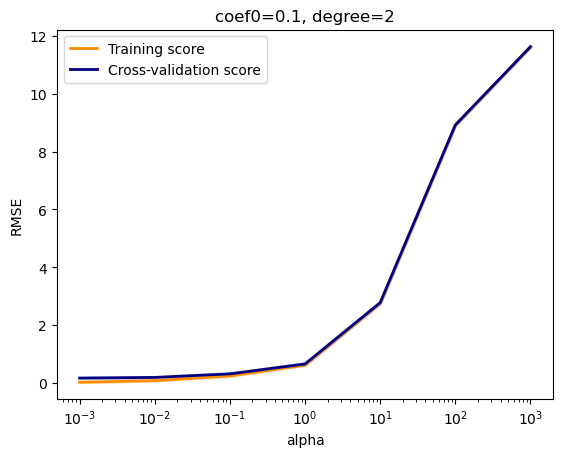

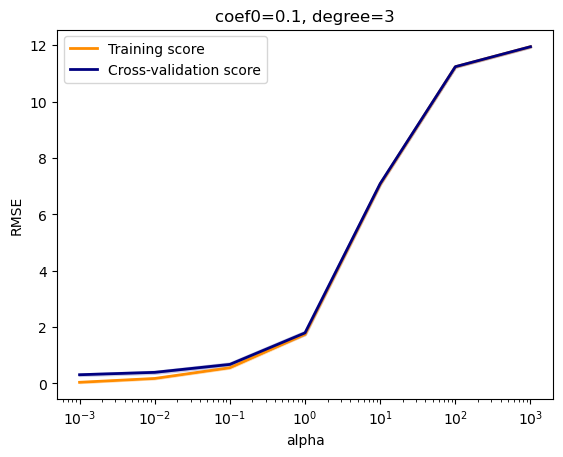

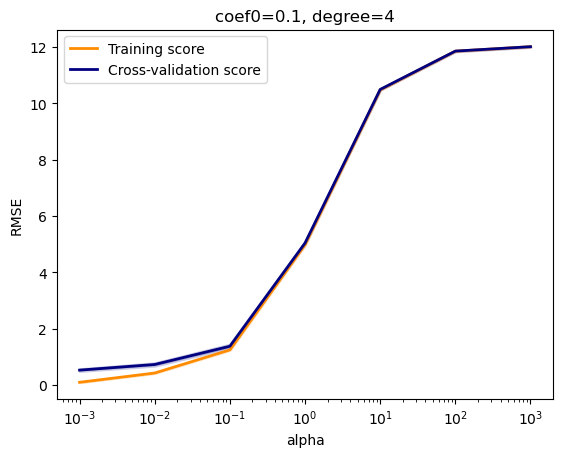

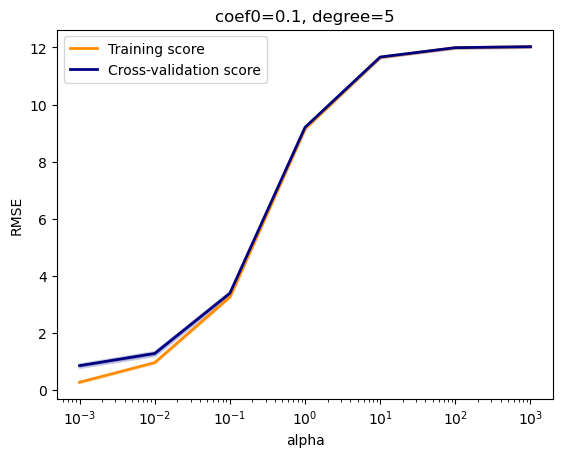

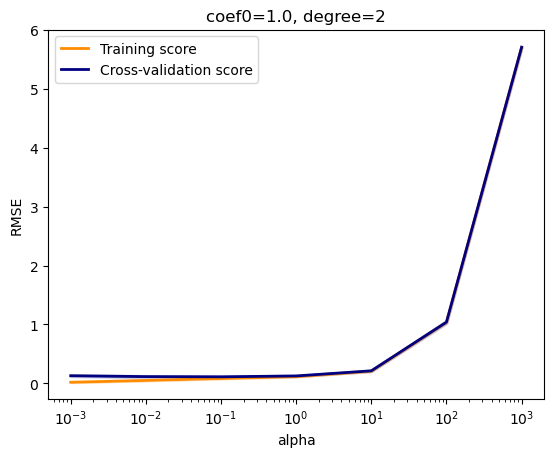

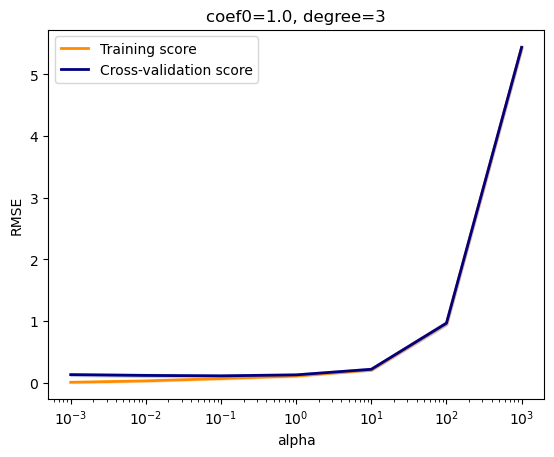

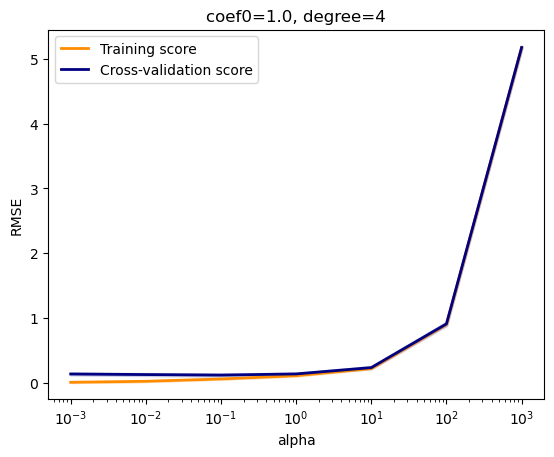

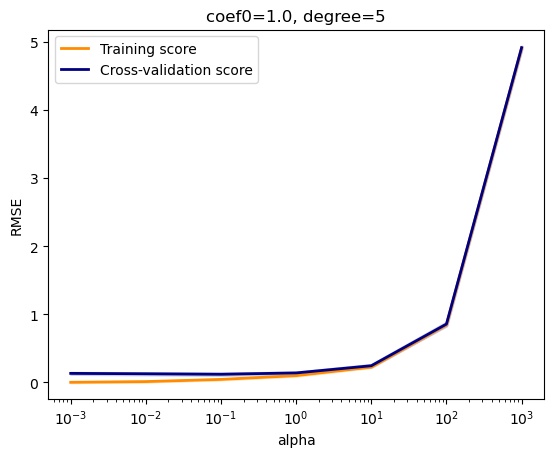

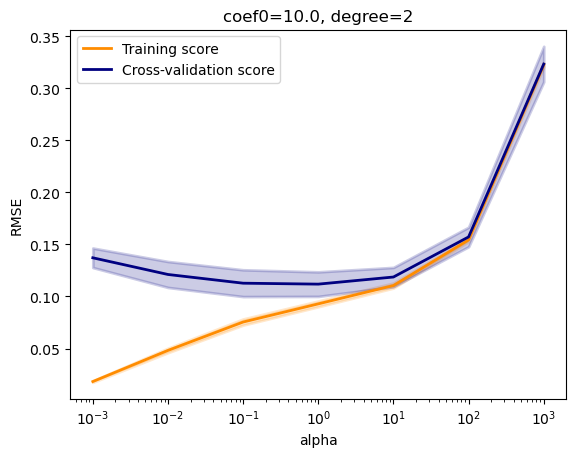

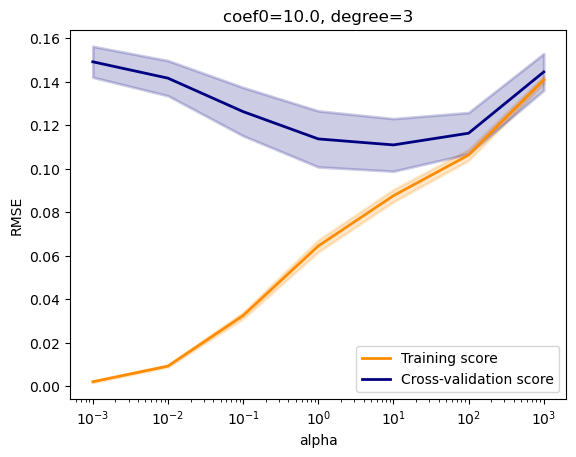

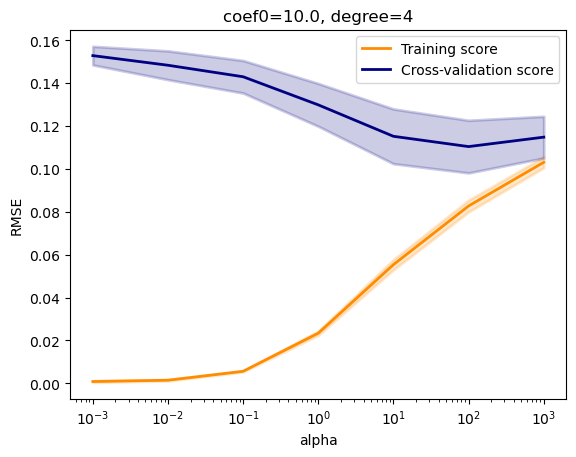

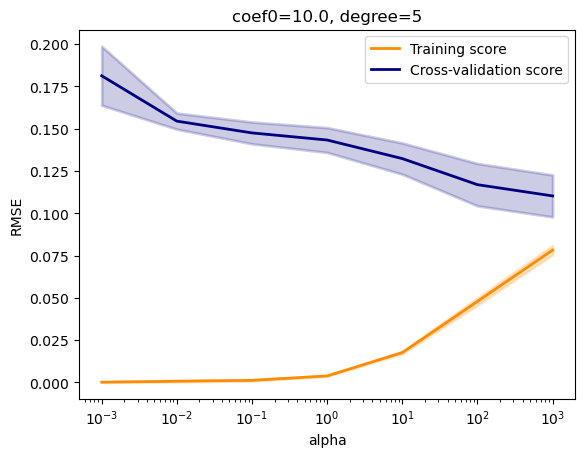

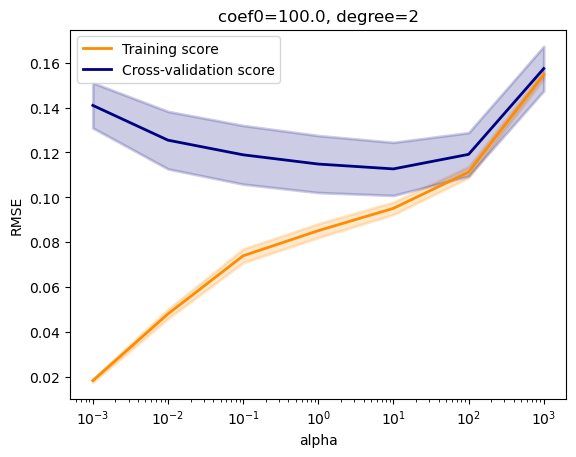

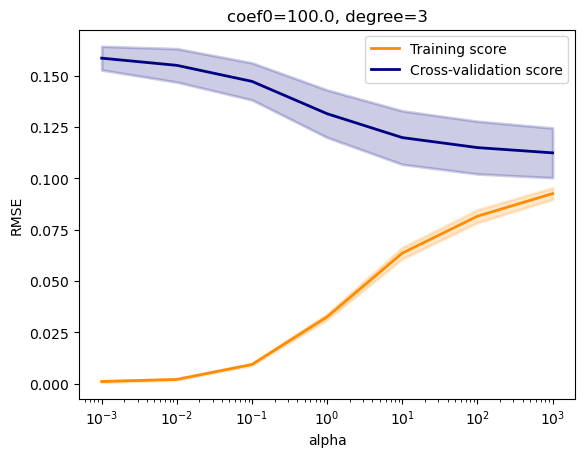

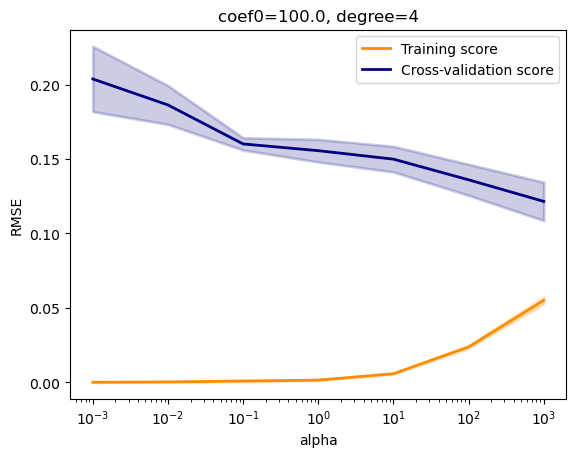

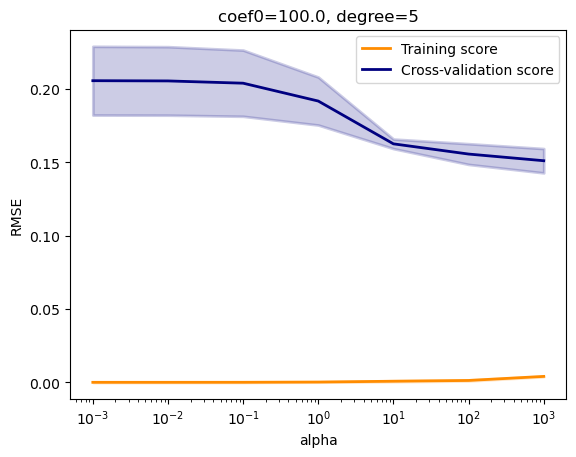

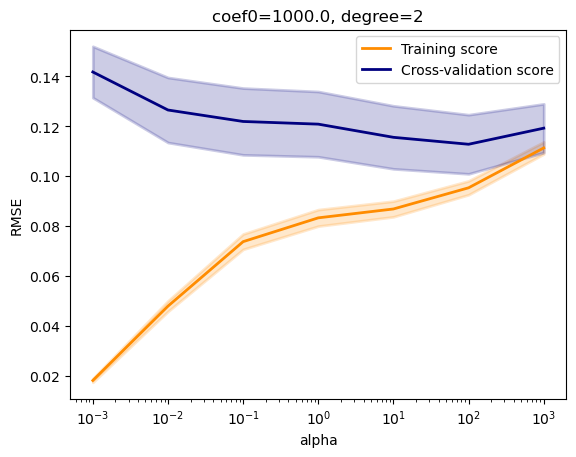

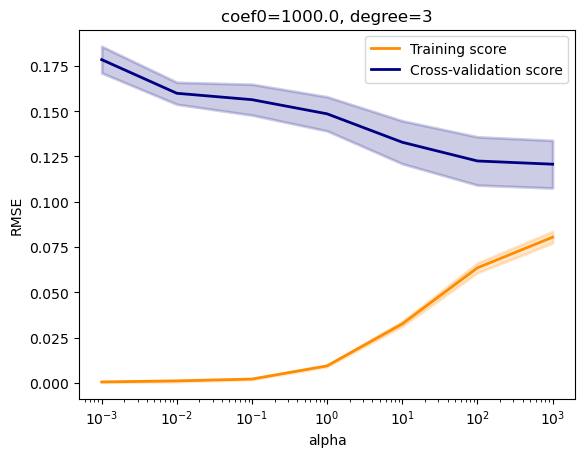

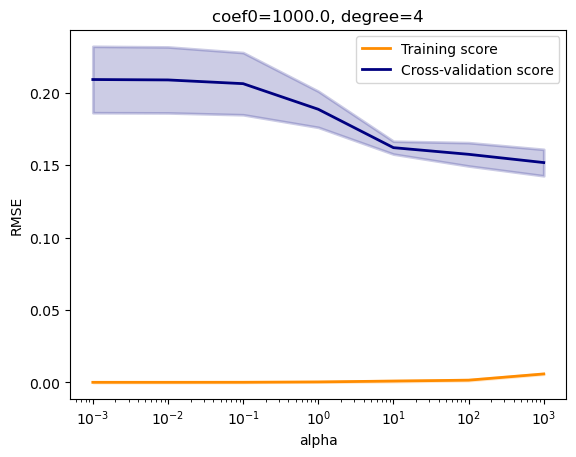

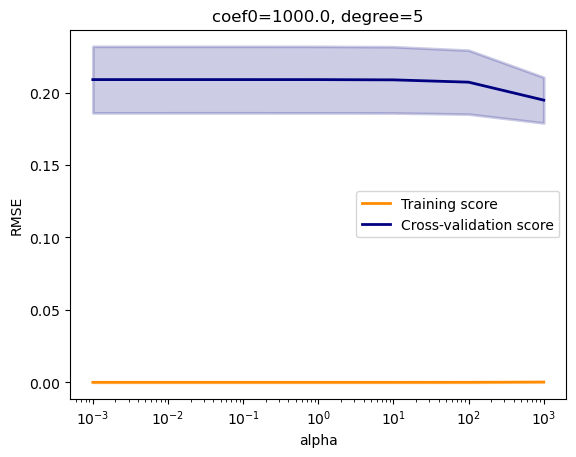

In [96]:
plot_validation_scores(best_kernel_ridge, "alpha")

In [112]:
# Manually tuned.
kernel_ridge = KernelRidge(kernel='polynomial', degree=2, coef0=10, alpha=10)
cv_scores = fit_cv(kernel_ridge, X_onehot_train)
print(f"Kernel Ridge:")
print_nosearch_results(kernel_ridge, cv_scores, X_onehot_train, X_onehot_holdout)

Kernel Ridge:
    Mean CV RMSE: 0.1187
    Train RMSE: 0.1097
    Holdout RMSE: 0.2180

    Train RMSE: $19,937
    Holdout RMSE: $137,833


## Gradiant Boosting

In [119]:
np.logspace(-3, 0, num=4)

array([0.001, 0.01 , 0.1  , 1.   ])

In [120]:
grad_boosting = GradientBoostingRegressor()
param_grid = {
    "n_estimators": [100, 500, 1000],
    "max_depth": [1, 2, 3, 4],
    "subsample": [0.25, 0.5, 0.75, 1.0],
    "learning_rate": np.logspace(-3, 0, num=4),
}
best_grad_boosting = fit_grid_search_cv(grad_boosting, param_grid, X_ordinal_train)
best_params = best_grad_boosting.best_params_
print(f"Gradient Boosting(n_estimators={best_params['n_estimators']}, max_depth={best_params['max_depth']}, subsample={best_params['subsample']}, learning_rate={best_params['learning_rate']}):")
print_search_results(best_grad_boosting, X_ordinal_train, X_ordinal_holdout)

Gradient Boosting(n_estimators=1000, max_depth=4, subsample=0.25):
    Mean CV RMSE: 0.1169
    Train RMSE: 0.0646
    Holdout RMSE: 0.1657

    Train RMSE: $12,292
    Holdout RMSE: $50,517


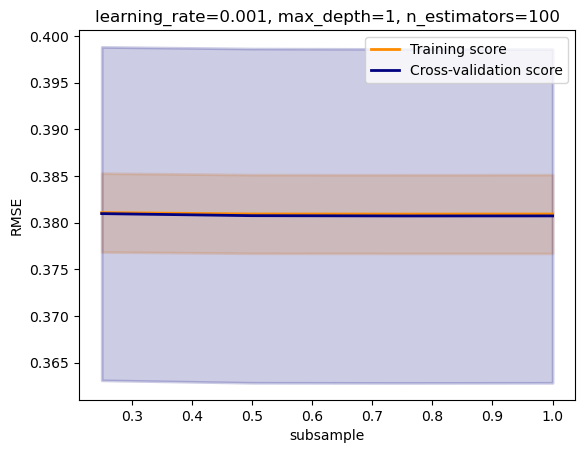

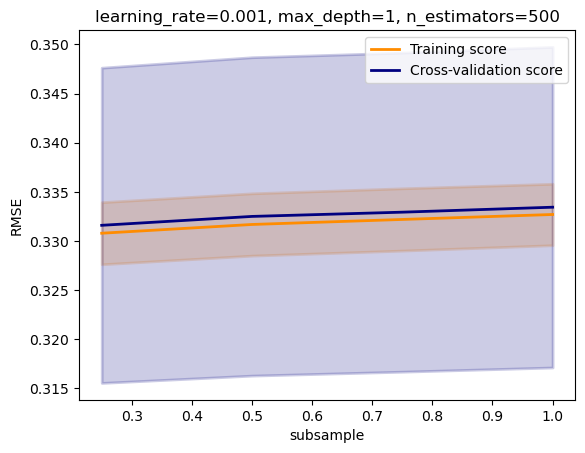

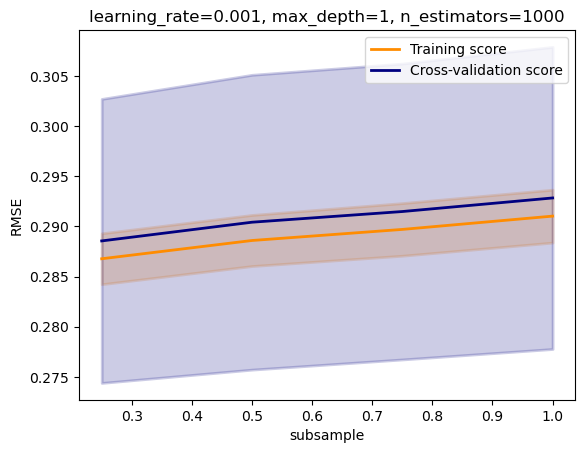

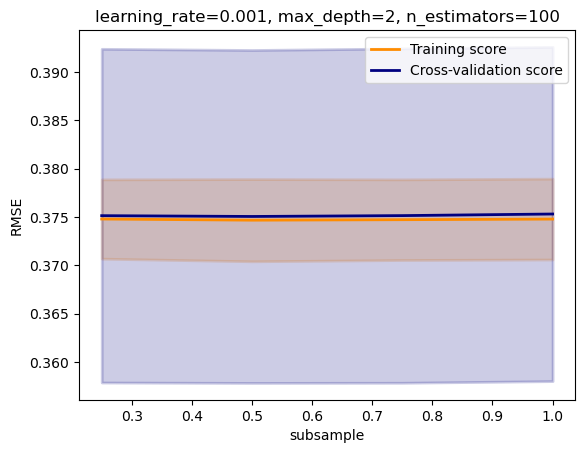

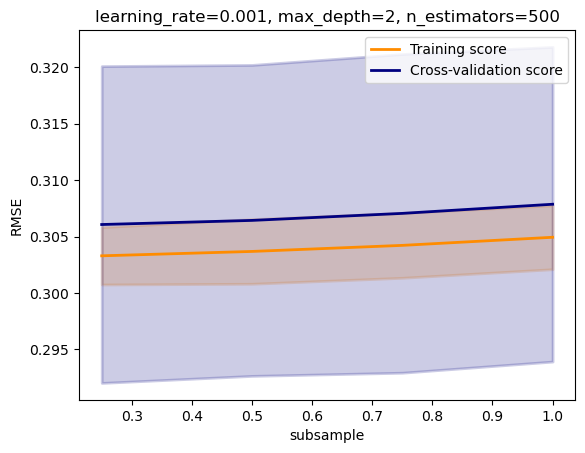

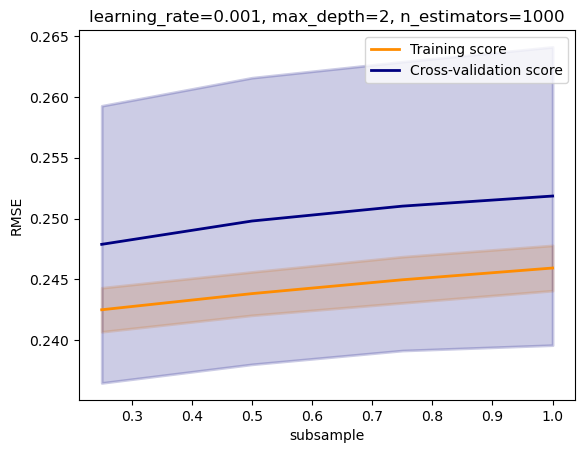

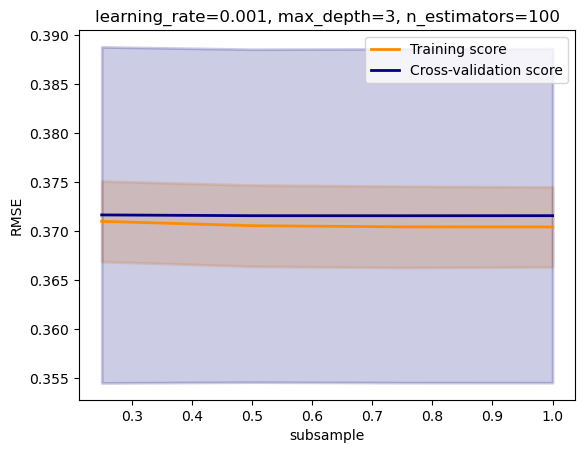

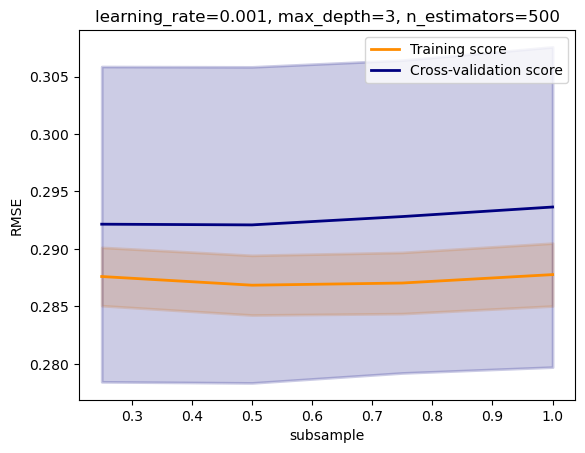

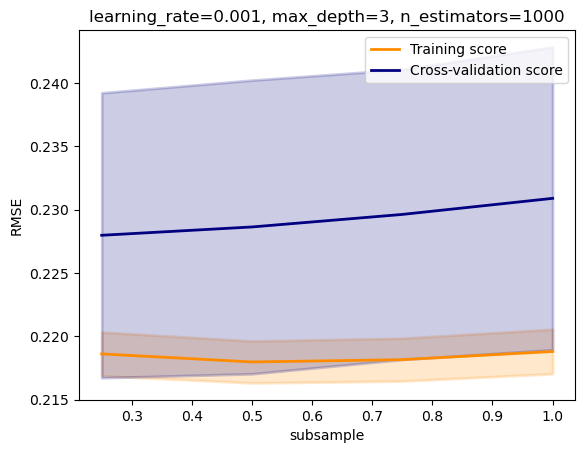

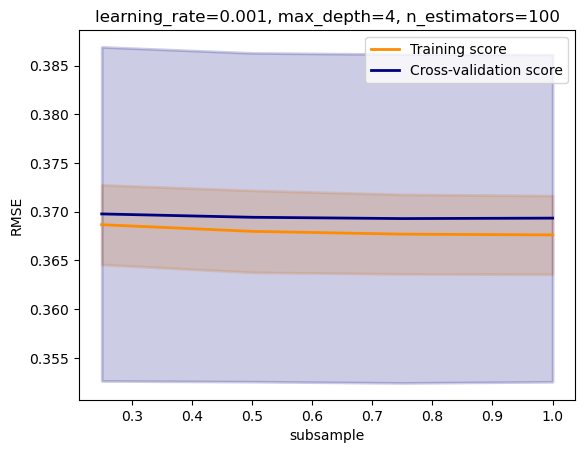

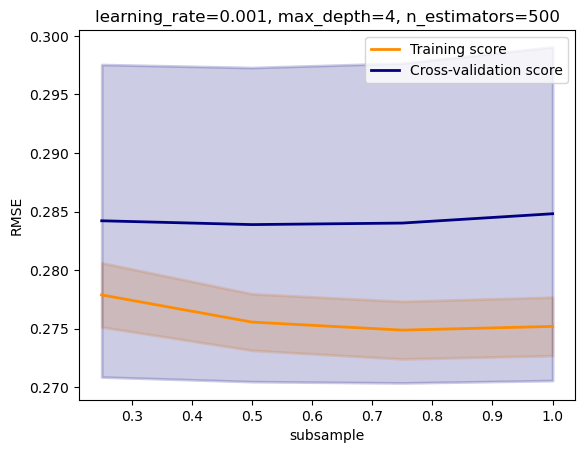

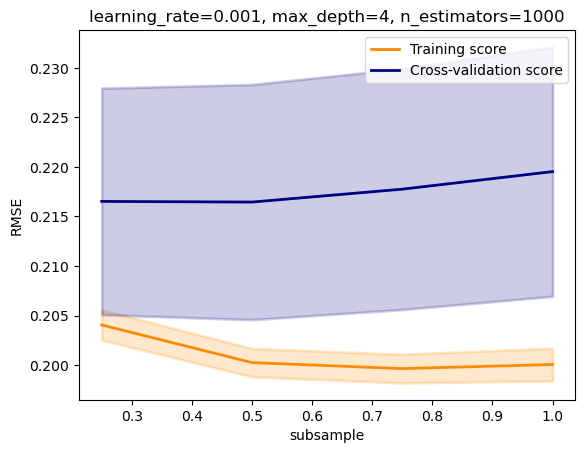

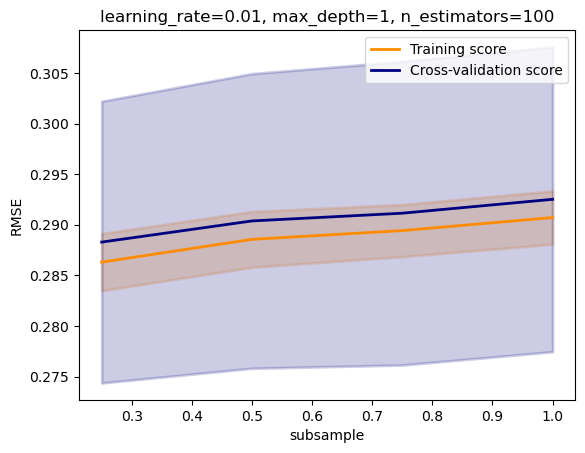

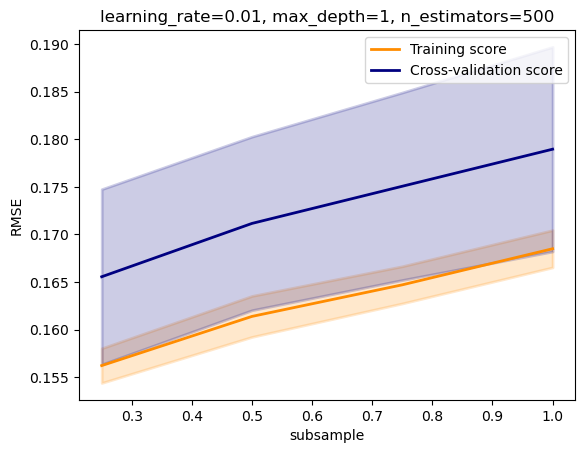

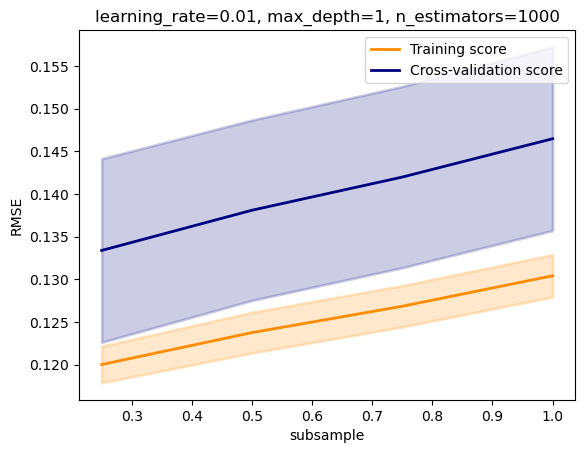

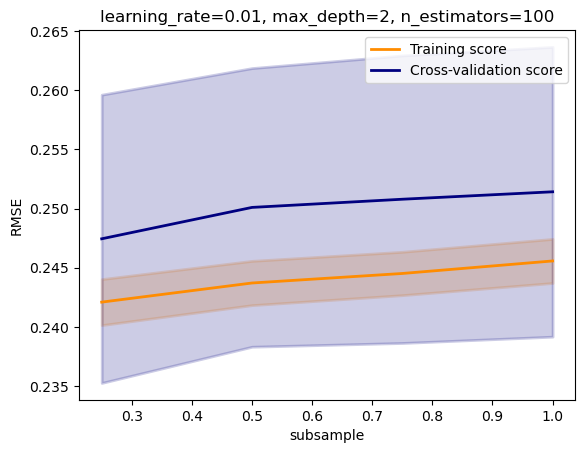

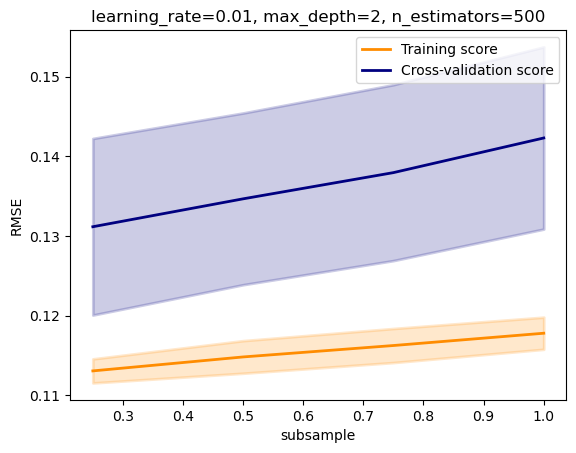

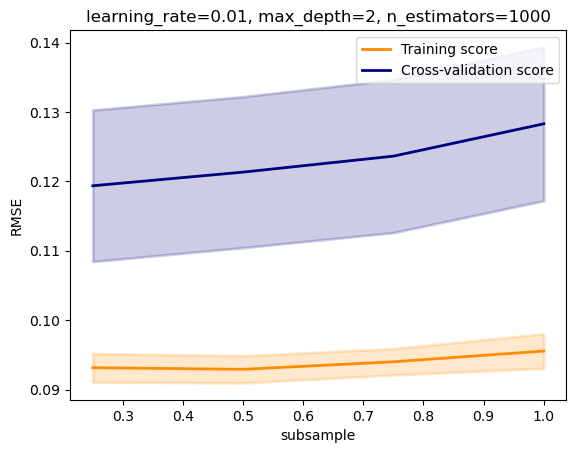

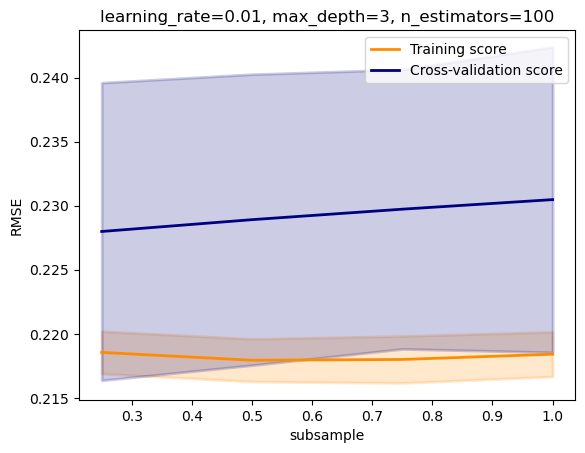

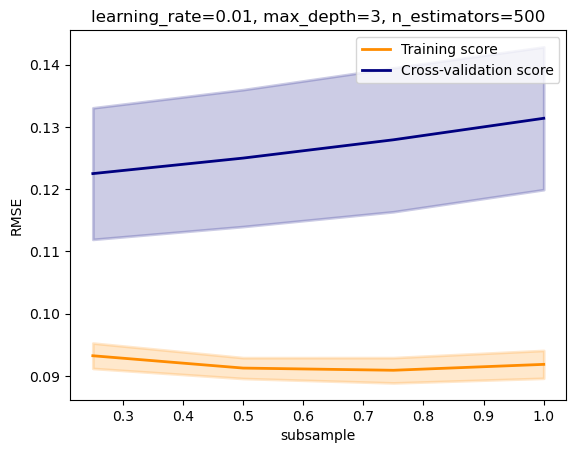

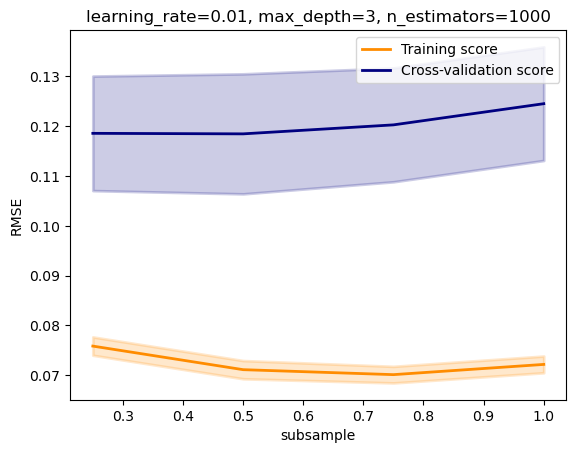

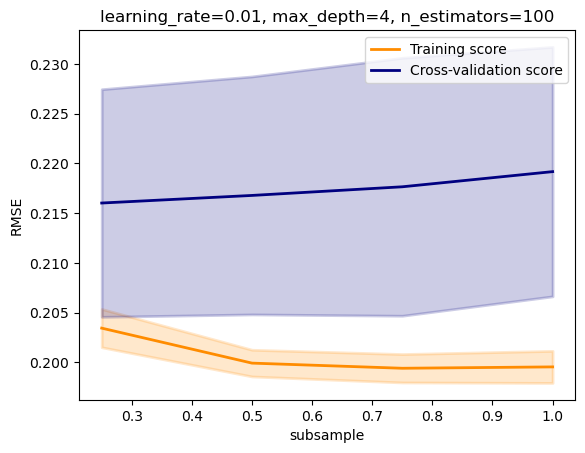

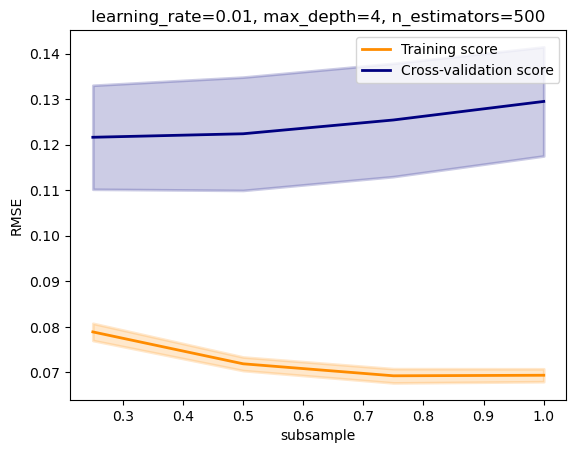

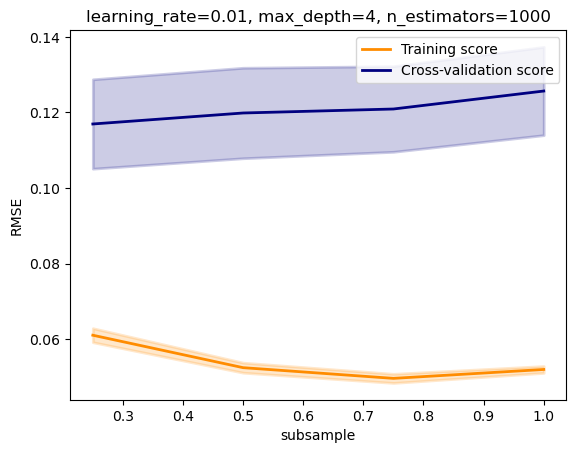

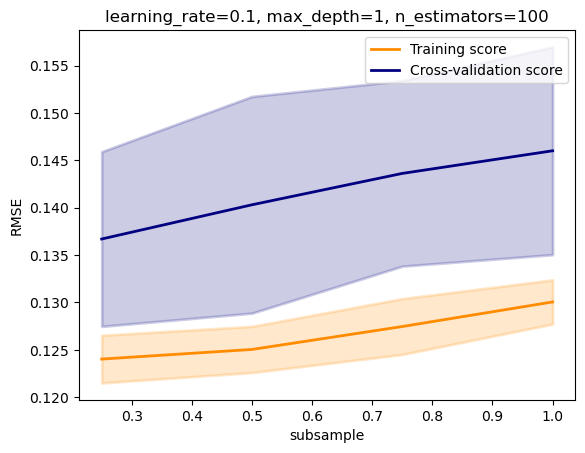

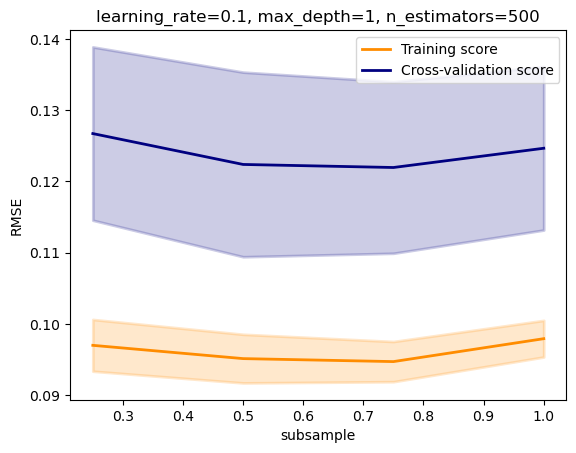

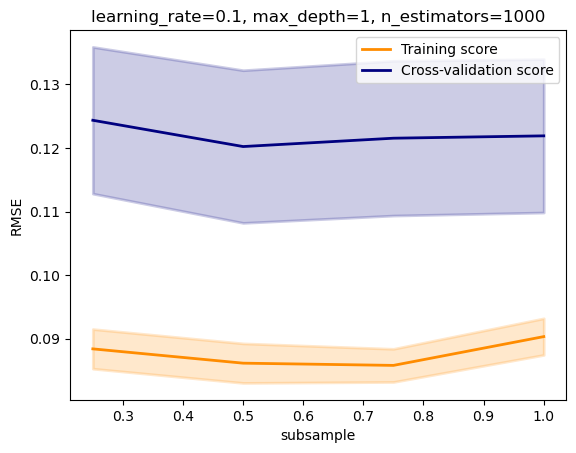

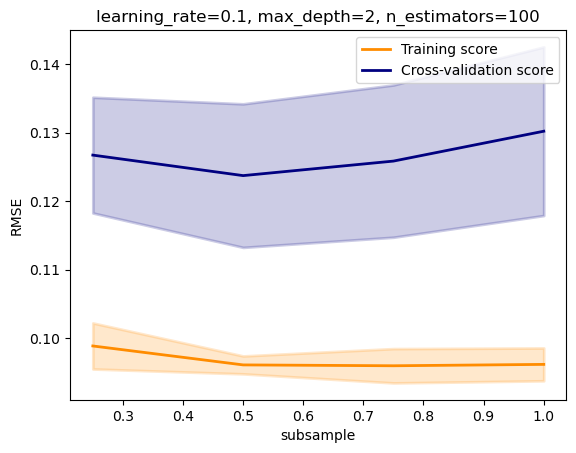

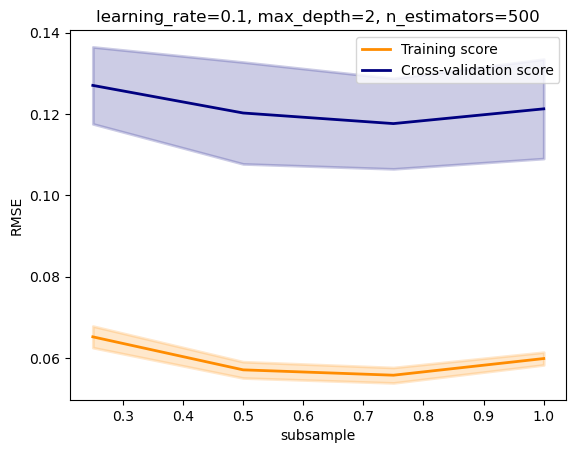

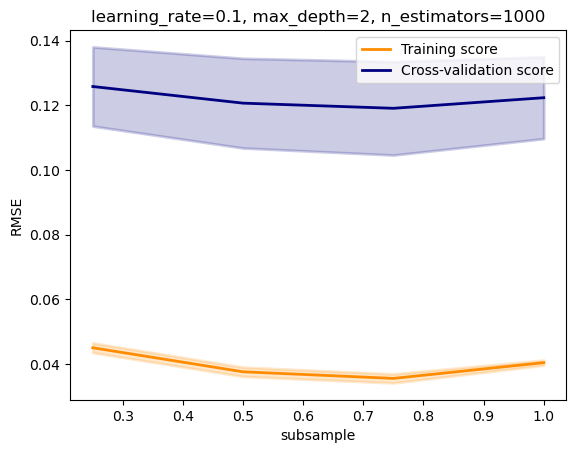

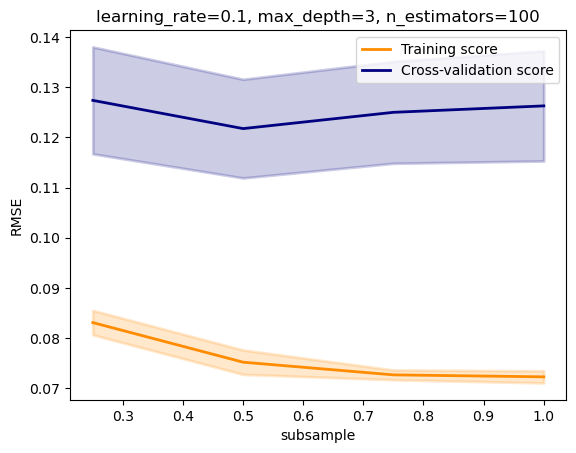

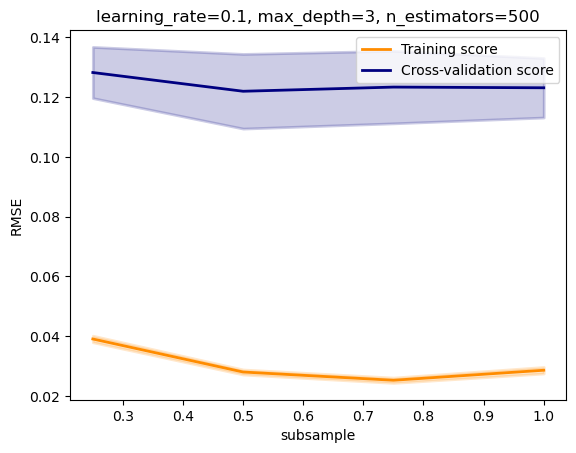

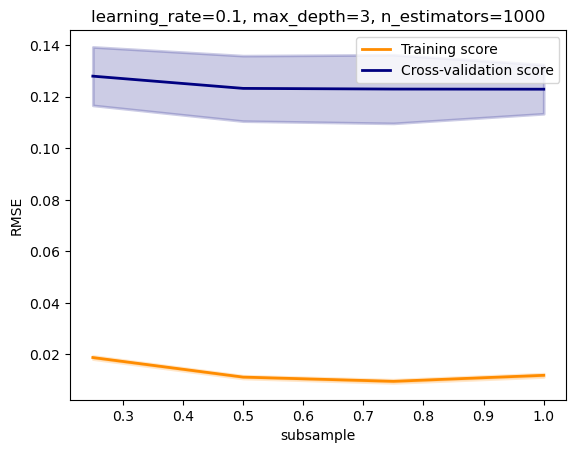

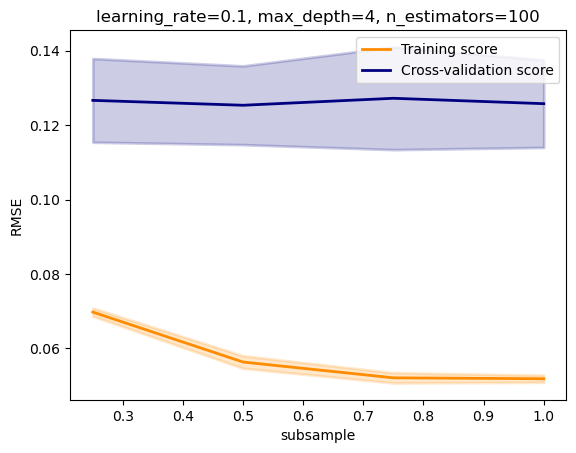

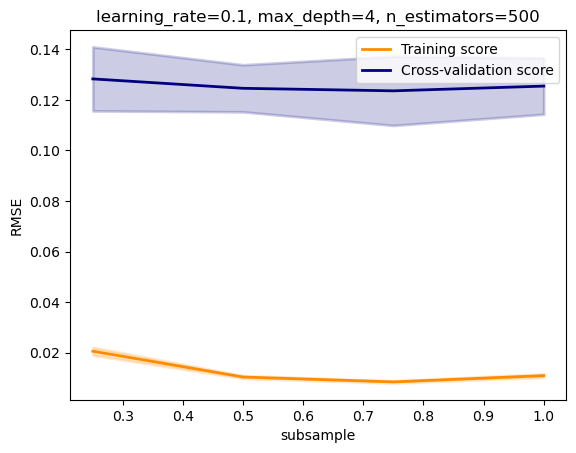

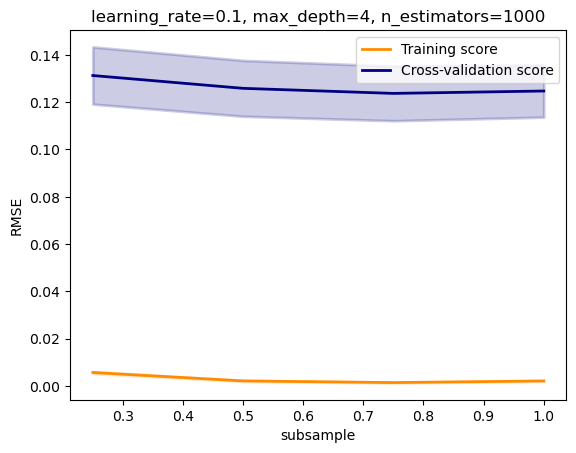

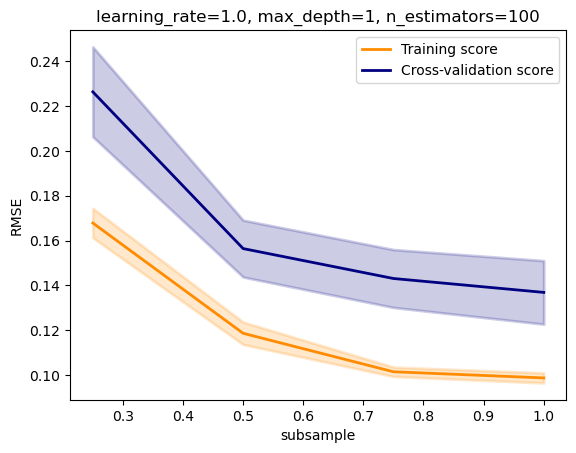

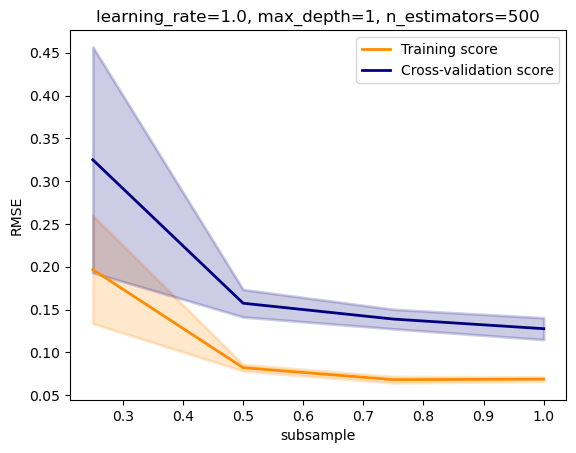

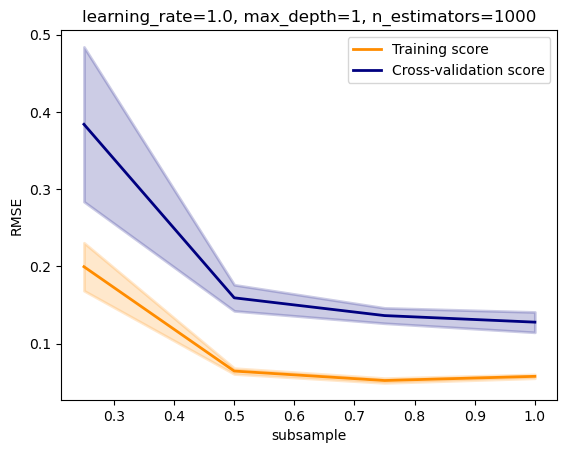

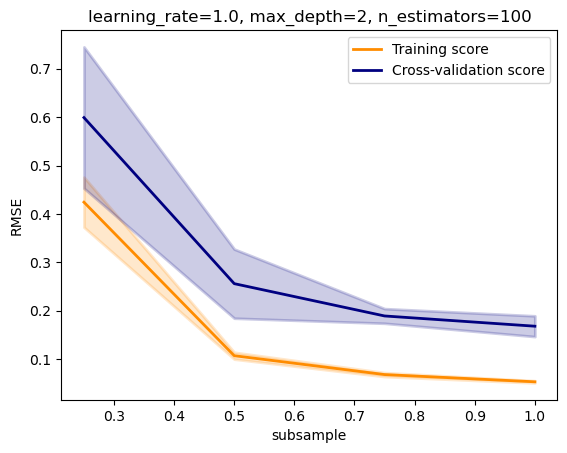

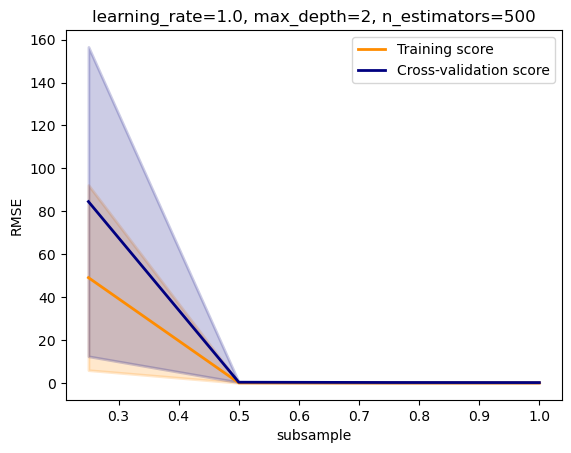

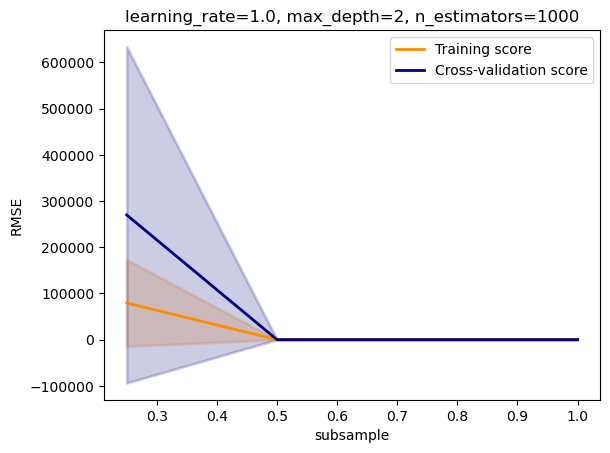

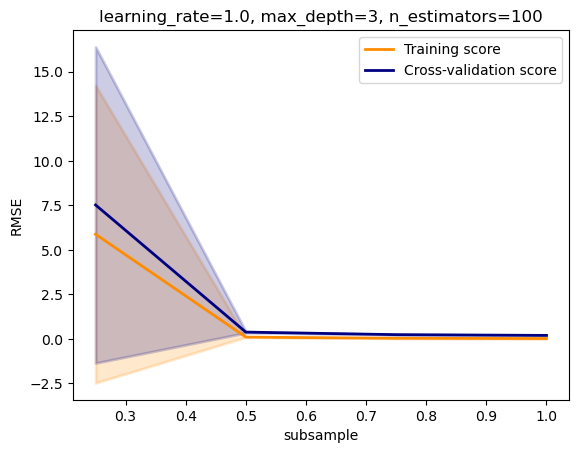

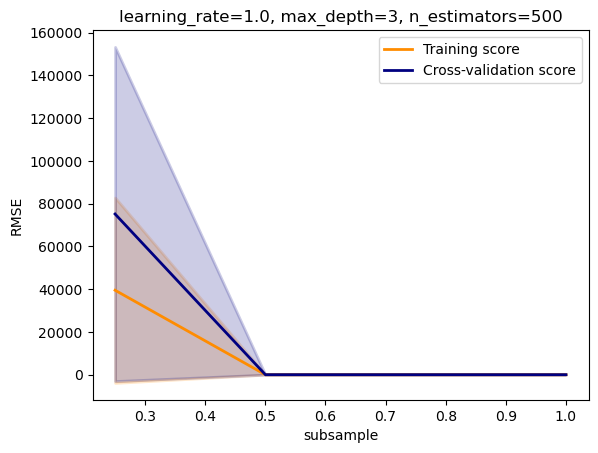

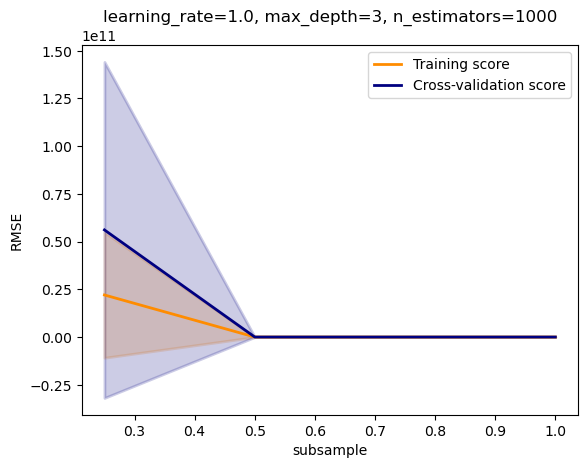

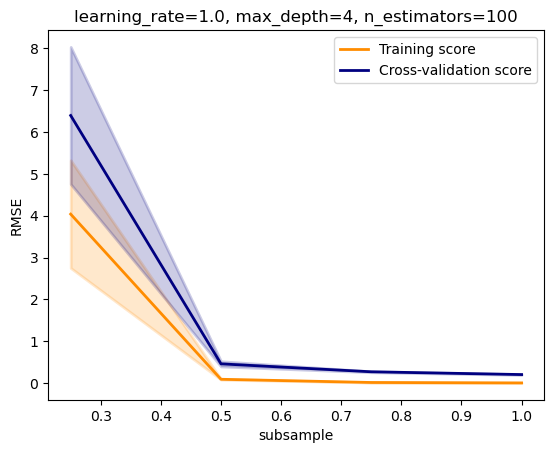

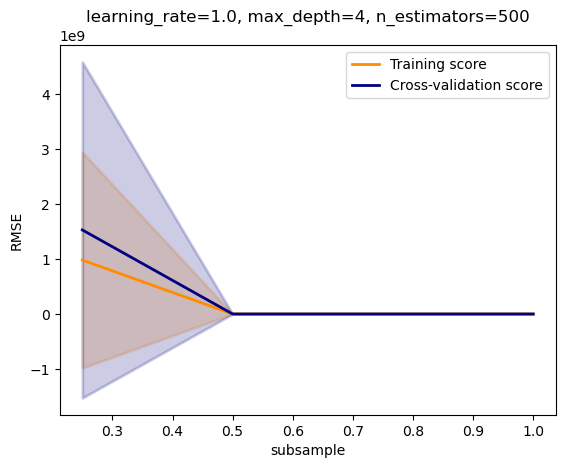

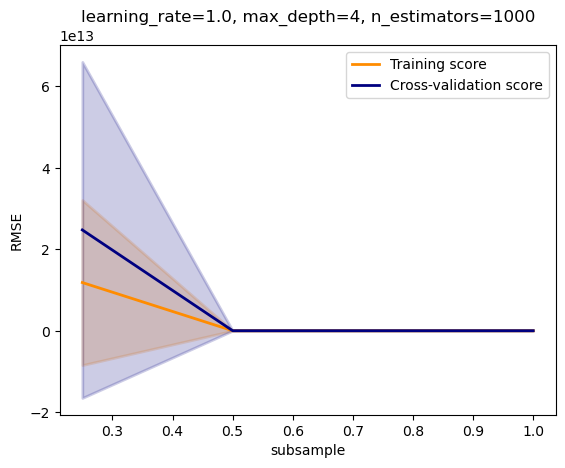

In [121]:
plot_validation_scores(best_grad_boosting, "subsample")

In [123]:
# Fine tuned
grad_boosting = GradientBoostingRegressor()
param_grid = {
    "n_estimators": [500, 1000],
    "max_depth": [1, 2, 3, 4],
    "subsample": [0.05, 0.1, 0.25],
    "learning_rate": [0.01],
}
best_grad_boosting = fit_grid_search_cv(grad_boosting, param_grid, X_ordinal_train)
best_params = best_grad_boosting.best_params_
print(f"Gradient Boosting(n_estimators={best_params['n_estimators']}, max_depth={best_params['max_depth']}, subsample={best_params['subsample']}, learning_rate={best_params['learning_rate']}):")
print_search_results(best_grad_boosting, X_ordinal_train, X_ordinal_holdout)

Gradient Boosting(n_estimators=1000, max_depth=4, subsample=0.25, learning_rate=0.01):
    Mean CV RMSE: 0.1162
    Train RMSE: 0.0648
    Holdout RMSE: 0.1644

    Train RMSE: $12,363
    Holdout RMSE: $49,174


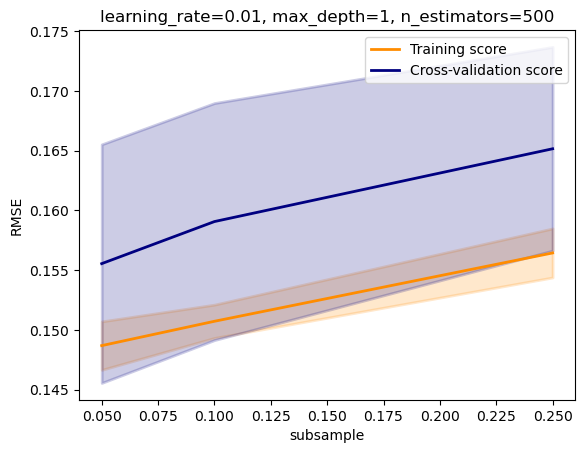

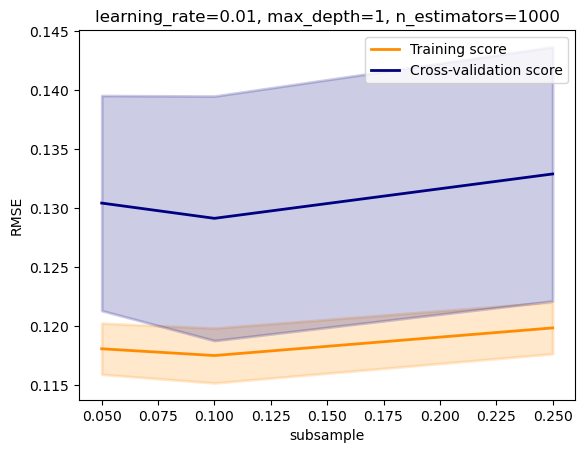

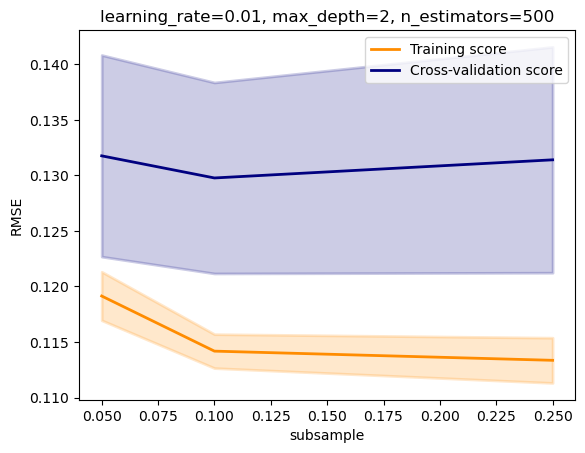

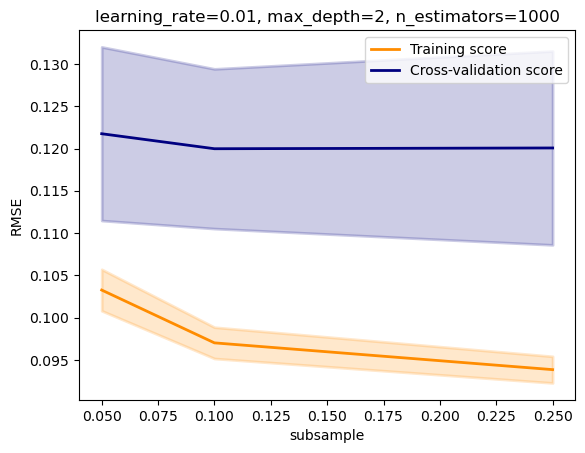

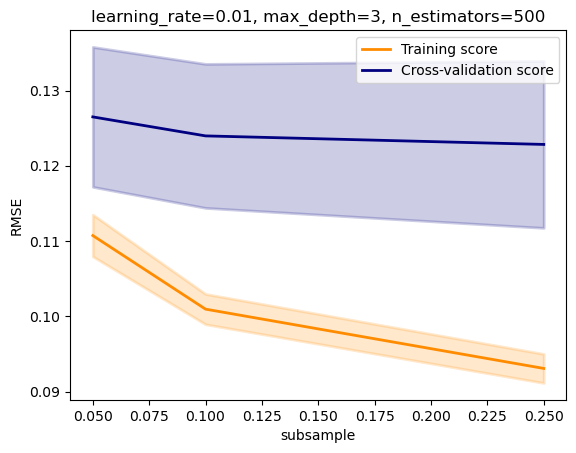

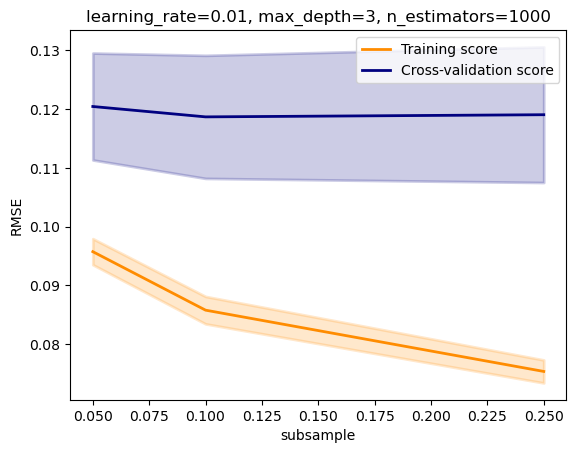

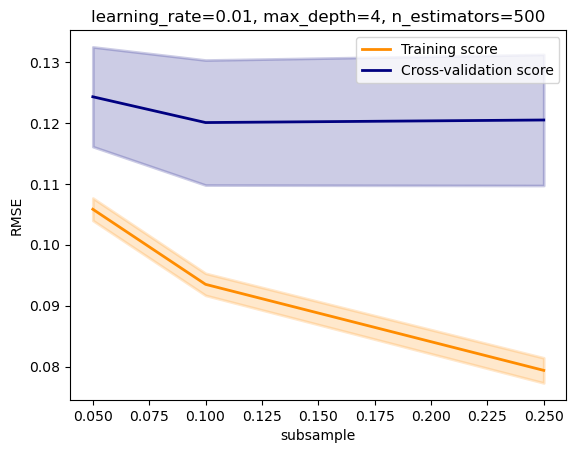

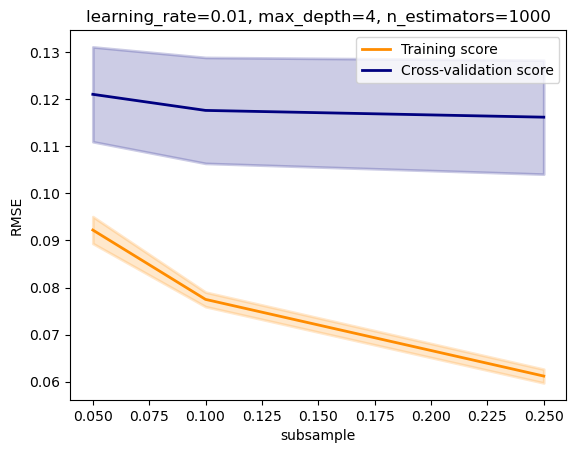

In [124]:
plot_validation_scores(best_grad_boosting, "subsample")

In [125]:
# Manually tuned
grad_boosting = GradientBoostingRegressor(n_estimators=1000, max_depth=4, subsample=0.1, learning_rate=0.01)
cv_scores = fit_cv(grad_boosting, X_onehot_train)
print(f"Gradient Boosting:")
print_nosearch_results(grad_boosting, cv_scores, X_onehot_train, X_onehot_holdout)

Gradient Boosting:
    Mean CV RMSE: 0.1179
    Train RMSE: 0.0809
    Holdout RMSE: 0.1599

    Train RMSE: $15,511
    Holdout RMSE: $46,164


## Gradient Boosting (one-hot encoded data)

In [9]:
grad_boosting = GradientBoostingRegressor()
param_grid = {
    "n_estimators": [10, 100, 500],
}
best_grad_boosting = fit_grid_search_cv(grad_boosting, param_grid, X_onehot_train)
best_params = best_grad_boosting.best_params_
print(f"Gradient Boosting(n_estimators={best_params['n_estimators']}):")
print_search_results(best_grad_boosting, X_onehot_train, X_onehot_holdout)

Gradient Boosting(n_estimators=500):
    Mean CV RMSE: 0.1202
    Train RMSE: 0.0363
    Holdout RMSE: 0.1669

    Train RMSE: $6,590
    Holdout RMSE: $51,839


## AdaBoost

In [50]:
adaboost = AdaBoostRegressor()
param_grid = {
    "n_estimators": [10, 100, 500],
}
best_adaboost = fit_grid_search_cv(adaboost, param_grid, X_ordinal_train)
best_params = best_adaboost.best_params_
print(f"AdaBoost(n_estimators={best_params['n_estimators']}):")
print_search_results(best_adaboost, X_ordinal_train, X_ordinal_holdout)

AdaBoost(n_estimators=500):
    Mean CV RMSE: 0.1647
    Train RMSE: 0.1421
    Holdout RMSE: 0.1811

    Train RMSE: $27,692
    Holdout RMSE: $41,771


## AdaBoost (one-hot encoded data)

In [11]:
adaboost = AdaBoostRegressor()
param_grid = {
    "n_estimators": [10, 100, 500],
}
best_adaboost = fit_grid_search_cv(adaboost, param_grid, X_onehot_train)
best_params = best_adaboost.best_params_
print(f"AdaBoost(n_estimators={best_params['n_estimators']}):")
print_search_results(best_adaboost, X_onehot_train, X_onehot_holdout)

AdaBoost(n_estimators=500):
    Mean CV RMSE: 0.1631
    Train RMSE: 0.1446
    Holdout RMSE: 0.1868

    Train RMSE: $27,693
    Holdout RMSE: $44,367


## Stacking Model

In [12]:
base_models = [
    ("ridge", Ridge(alpha=10)),
    ("lasso", Lasso(alpha=0.001)),
    ("svm", SVR(kernel="rbf", C=0.8)),
    ("rf", RandomForestRegressor(n_estimators=800, max_features=1.0, min_samples_leaf=1)),
    ("gradboost", GradientBoostingRegressor(n_estimators=500)),
]
meta_model_param_grid = {
    "alpha": np.logspace(-3, 3, num=7),
}
meta_model = GridSearchCV(Ridge(), meta_model_param_grid, scoring="neg_root_mean_squared_error")
stacked = StackingRegressor(base_models, meta_model, cv=5, n_jobs=-1)
stacked.fit(X_onehot_train, y_train)
best_params = stacked.final_estimator_.best_params_
print(f"Stacked model(alpha={best_params['alpha']}):")
print_results(stacked, stacked.final_estimator_.best_score_, X_onehot_train, X_onehot_holdout)

Stacked model(alpha=0.1):
    Mean CV RMSE: 0.1099
    Train RMSE: 0.0754
    Holdout RMSE: 0.2094

    Train RMSE: $13,673
    Holdout RMSE: $123,279


## LightGBM

In [ ]:
# pip install lightgbm

In [20]:
lgbm = ltb.LGBMRegressor()
param_grid = {
    "n_estimators": [10, 50, 100, 500, 700],
    "reg_alpha": [0.5, 1, 2, 5, 10, 50, 100, 200],
    "reg_lambda": [0.5, 1, 2, 5, 10],
}
best_lgbm = fit_grid_search_cv(lgbm, param_grid, X_ordinal_train)
best_params = best_lgbm.best_params_
print(f"LGBM Regressor (n_estimators={best_params['n_estimators']}, reg_alpha={best_params['reg_alpha']}, reg_lambda={best_params['reg_lambda']}):")
print_search_results(best_lgbm, X_ordinal_train, X_ordinal_holdout)

LGBM Regressor (n_estimators=100, reg_alpha=50, reg_lambda=0.5):
    Mean CV RMSE: $26,452
    Train RMSE: $10,984
    Holdout RMSE: $39,835


## XGBoost

In [ ]:
# pip install xgboost
# https://xgboost.readthedocs.io/en/stable/parameter.html

In [28]:
xgb = xgb.XGBRegressor()
param_grid = {
    "n_estimators": [10, 50, 100, 500, 700, 1000],
    "max_depth": [2, 5, 10, 50, 100, 200],
}
best_xgb = fit_grid_search_cv(xgb, param_grid, X_ordinal_train)
best_params = best_xgb.best_params_
print(f"XGBoost Regressor (n_estimators={best_params['n_estimators']}, max_depth={best_params['max_depth']}):")
print_search_results(best_xgb, X_ordinal_train, X_ordinal_holdout)

XGBoost Regressor (n_estimators=1000, max_depth=2):
    Mean CV RMSE: $24,826
    Train RMSE: $3,425
    Holdout RMSE: $53,697


# Run final model on test/eval data

In [16]:
# Load training data.
train_data = pd.read_csv("train.csv", index_col="Id")

In [17]:
# Obtain target and feature columns.
target = "SalePrice"
all_features = train_data.drop(columns=target).columns

In [18]:
# Log-transform target
train_data['Log_SalePrice'] = np.log(train_data.SalePrice)
target = "Log_SalePrice"

In [19]:
# Perform feature extraction.
feature_extract = housing.FeatureExtracter()
X_train_all = feature_extract.fit_transform(train_data[all_features])
y_train_all = train_data[target]

In [20]:
# Load and extract features from eval set.
eval_data = pd.read_csv("test.csv", index_col="Id")
assert target not in eval_data.columns, f"Did not expect target ({target}) column in eval data"
X_eval = feature_extract.transform(eval_data)

In [ ]:
final_model = Pipeline([
    ("cat", ColumnTransformer([
            ("onehot", OneHotEncoder(drop="if_binary", handle_unknown="ignore", sparse=False), feature_extract.get_categorical_feature_names()),
            ("scaler", StandardScaler(), feature_extract.get_numeric_feature_names()),
        ], remainder="passthrough")),
    ('reg', SVR(kernel="rbf", C=0.3, epsilon=0.001)),
])
final_model.fit(X_train_all, y_train_all)
y_train_pred = final_model.predict(X_train_all)
y_eval_pred = final_model.predict(X_eval)
print(f"Training RMSE: {metrics.mean_squared_error(y_train_all, y_train_pred, squared=False):.4f}")

In [25]:
# Write results to file for submission.
output_filename = "submission.csv"
pd.Series(np.exp(y_eval_pred), name="SalePrice", index=eval_data.index).to_csv(output_filename)
print(f"Results written to: {output_filename}")

Results written to: submission.csv
